# 1. Defining the Data Science problem here
---
>**This project's data science problem is to build a model that will predict the price of a house at sale in Ames, Iowa before a sale.**
<br>The final model selected here is a MLR with 3 features capturing: **Area, Age and Quality datapoints.**
<br>Included in this notebook includes models built on:
    - Single Linear Regression
    - Lasso Regression
    - Ridge Regression
    - Elastic Net

Despite some of the other models offering better predictive powers, the MLR was selected because of it is easy to simple to understand and to explain to other stakeholders such as realtors or house owners that might have an interest in this problem. It is not easy to explain a model with 30 predictors.

The model created here is created using a regression model based on the [Ames Housing Dataset](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge).

The data dictionary for the dataset could be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).
<br>
<br>The limitation of the models created here include:
    - will need to modify the age calculation used (2010 - year of remod)
    - unable to accurately predict large houses
    - houses with unique characteristics such as missing sewarage, no central aircon etc as there are not 
    enough samples to predict accurartely
    - like many models, this is not an evergreen model.. 

# Content

- [2. Gathering the data](#2.-Gathering-the-data)

- [3. Exploring and cleaning the data](#3.-Exploring-and-cleaning-the-data)
        - Filling of null data
        - Dropping of rows with lots of missing data
        
- [4. Exploratory Data Plots](#4.-Exploratory-Data-Plots)
        - Scatterplot
        - Histogram
        - Boxplot
        - dropping of big outliers
        
- [5. Baseline model creation](#5.-Baseline-model-creation)
        - Plotting of heatmap 
        - Construction of SLR
        
- [6. Our simple 3 variable Multi Linear Regressor](#6.-Our-simple-3-variable-Multi-Linear-Regressor)
        - Filtering of more variables
        - Construction of MLR
        
- [7. Embedded method of feature selection](#7.-Embedded-method-of-feature-selection)
        - Lasso Regression
        - Elastic Net
        - Ridge Regression
        - Feature selection based on Ridge
        - Ridge Regression on remaining features
        
- [8. Conclusion](#8.-Conclusion)
        - Choice of model
        
- [9. Kaggle](#9.-Kaggle)
        - Prediction
        - Submission        

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

<a id='2.-Gathering-the-data'></a>
# 2. Gathering the data

**Data is provided here**


In [2]:
# load the training set
train = pd.read_csv('datasets/train.csv')

<a id='3.-Exploring-and-cleaning-the-data'></a>
# 3. Exploring and cleaning the data

In [3]:
# Using the .info to have a glance at the dtype, missing values etc
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

Based on the info above, there are missing values to be fixed and I also went to cross-check against the data dictionary to make sure there dtypes are correct. 

- `MS SubClass` is categorical despite being int64 and it is a combination of a few features such as area and year. Will fix it to convert into a `string`.
- Decided to drop `PID` since they will not affect price, retain Id and reset it to be the index.


In [4]:
# drop PID column
train.drop(columns=['PID'],inplace=True)

In [5]:
# resetting index to use Id as index
train.set_index(keys='Id',inplace=True)

In [6]:
# Fix MS Subclass so that it can be 1 hot encoded later
train['MS SubClass'] = train['MS SubClass'].apply(lambda x: str(x))

In [7]:
# sum of isnull() is better than manual calculation
train.isnull().sum().sort_values(ascending=False)

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Qual         114
Garage Cond         114
Garage Yr Blt       114
Garage Finish       114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
Bsmt Qual            55
BsmtFin Type 1       55
Bsmt Cond            55
Mas Vnr Type         22
Mas Vnr Area         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Bsmt Unf SF           1
Total Bsmt SF         1
BsmtFin SF 1          1
BsmtFin SF 2          1
Garage Cars           1
Garage Area           1
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
Roof Style            0
                   ... 
Condition 2           0
Heating QC            0
Foundation            0
Heating               0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch  

Based on the data dictionary. Here's my thinking:

**1.** `NA` is causing null values in: `Pool QC`,`Misc Feature`,`Alley`,`Fence`,`Fireplace Qu`,`Lot Frontage`,`Garage Qual`, `Garage Cond`,`Garage Yr Blt`,`Garage Finish`,`Garage Type`,`Bsmt Exposure`,`BsmtFin Type 2`,`Bsmt Qual`,`BsmtFin Type 1`, `Bsmt Cond`,`Mas Vnr Type`,`Mas Vnr Area`, `Bsmt Half Bath`,`Bsmt Full Bath`, `Bsmt Unf SF`, `Total Bsmt SF`, `BsmtFin SF 1`, `BsmtFin SF 2`, `Garage Cars` & `Garage Area`.<p>

**2.** Some features maybe combined?
- `Year Built` and `Year Remod/Add` maybe can combined or replaced for 1 another ???
- `Exterior 1` &  `Exterior 2`'s `AsbShng` is Asbestos which is cancer-causing might have impact on price?<p>

**3.** Some of the null values maybe related?
- `Mas Vnr Type`'s None/NA causing null values?
- `Mas Vnr Area`'s missing values caused by the above's null?
- `Garage Type`'s None/NA causing null? 
- `Garage Yr Blt`'s null maybe due to above?
- `Misc Feature`'s None/NA causing null in categorical?
- `Misc Val`'s null related to above?


In [8]:
# added pd.set_option('display.max_columns', 100) on top to see the truncated columns.
# see alot of data points with 0 for min, 25%, 50% and 75% percentile.
train.describe()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


### Filling the null values

**1.** filled categorical with 'N.A' <p>

**2.** made use of relational fields to cross check ie `Mas Vnr Type` & `Mas Vnr Area`.

In [9]:
# For Categorical Alley that can be just filled.

train['Alley'].fillna('N.A',inplace=True)
train['Fence'].fillna('N.A',inplace=True)

# Fill this 2 since they are related and None is the mode of the data.
train['Mas Vnr Type'].fillna(str('None'),inplace=True)
train['Mas Vnr Area'].fillna(0,inplace=True)

# Fill this discrete
train['Lot Frontage'].fillna(0,inplace=True)

In [10]:
# check relational fileds and filling data.
# Pool Area has 0 filled.

print(train['Pool Area'].value_counts().get(0))
print(train['Pool QC'].isnull().sum())
# count of 0 show the same number of missing value of Pool QC.
train['Pool QC'].fillna('N.A',inplace=True)

2042
2042


In [11]:
print(train['Misc Val'].value_counts().get(0))
print(train['Misc Feature'].isnull().sum())

# count of 0 show the same number of missing value of Misc Feature .
train['Misc Feature'].fillna('N.A',inplace=True)

1986
1986


In [12]:
print(train['Fireplaces'].value_counts().get(0))
print(train['Fireplace Qu'].isnull().sum())

# count of 0 show the same number of missing value of Fireplace Qu.
train['Fireplace Qu'].fillna('N.A',inplace=True)

1000
1000


In [13]:
train.isnull().sum().sort_values(ascending=False)

Garage Qual        114
Garage Cond        114
Garage Yr Blt      114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Exterior 1st         0
Mas Vnr Type         0
Exterior 2nd         0
Roof Style           0
Mas Vnr Area         0
Exter Qual           0
Exter Cond           0
Foundation           0
Roof Matl            0
SalePrice            0
Year Remod/Add       0
Utilities            0
                  ... 
Fireplace Qu         0
Yr Sold              0
Mo Sold              0
Misc Val             0
Misc Feature         0
Fence                0
Pool QC              0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck S

In [14]:
# carve out a smaller subset to reduce the num of columns to display
outlier_garagecar = train[['Garage Type','Garage Qual','Garage Cond','Garage Yr Blt','Garage Finish','Garage Cars','Garage Area']]
display(outlier_garagecar[(outlier_garagecar['Garage Cars'].isnull())])

# empty Cars and Area belong to same row but type is Detchd.

# real missing data. - decide to drop
train.drop(2237,inplace=True)

,Garage Type,Garage Qual,Garage Cond,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area
Id,,,,,,,
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# fill up the Garage related after dropping missing data cell.

train['Garage Finish'].fillna('N.A',inplace=True)
train['Garage Qual'].fillna('N.A',inplace=True)
train['Garage Cond'].fillna('N.A',inplace=True)
train['Garage Type'].fillna('N.A',inplace=True)
train['Garage Yr Blt'].fillna(0,inplace=True)

In [16]:
# time to fix bsmt
train.isnull().sum().sort_values(ascending=False)

Bsmt Exposure      58
BsmtFin Type 2     56
Bsmt Qual          55
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Full Bath      2
Bsmt Half Bath      2
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 1        1
BsmtFin SF 2        1
Foundation          0
Exter Cond          0
Exter Qual          0
Mas Vnr Area        0
Mas Vnr Type        0
Exterior 2nd        0
Exterior 1st        0
Roof Matl           0
Roof Style          0
SalePrice           0
Year Built          0
Utilities           0
MS Zoning           0
Lot Frontage        0
Lot Area            0
Street              0
Alley               0
Lot Shape           0
Land Contour        0
                   ..
Enclosed Porch      0
Screen Porch        0
Sale Type           0
Pool Area           0
Pool QC             0
Fence               0
Misc Feature        0
Misc Val            0
Mo Sold             0
Yr Sold             0
Garage Cars         0
Garage Finish       0
Garage Yr Blt       0
Garage Type         0
Central Ai

In [17]:
# same as earlier to subset a smaller set for reading the columns
outlier_bsmt = train[['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2','Bsmt Full Bath','Bsmt Half Bath','Bsmt Unf SF','Total Bsmt SF']]

In [18]:
outlier_bsmt[(outlier_bsmt['BsmtFin SF 1'].isnull())]
# to check for the id of missing, also happens to be missing SF 2 and Unf

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,Total Bsmt SF
Id,,,,,,,,,,,
1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# def a funct to fix the data in bsmt in the train df and the smaller viewing subset
def checknfill(rowid):
    for i in outlier_bsmt.select_dtypes(include='object').columns:
        outlier_bsmt.loc[rowid,i] = 'N.A'
        train.loc[rowid,i] = 'N.A'
    for i in outlier_bsmt.select_dtypes(exclude='object').columns:
        outlier_bsmt.loc[rowid,i] = 0
        train.loc[rowid,i] = 0

In [20]:
# fill up Id 1342 because the cat of Bsmt is NA hence just fill all N.A and 0 across the row.
checknfill(1342)

C:\Users\himyn\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
outlier_bsmt[(outlier_bsmt['Bsmt Full Bath'].isnull())]
# id 1498 also no basement and some other partial fill

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,Total Bsmt SF
Id,,,,,,,,,,,
1498,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0


In [22]:
checknfill(1498)

In [23]:
#use the intercept of Cond and Qual and fill
intercept = outlier_bsmt[(outlier_bsmt['Bsmt Cond'].isnull()) & (outlier_bsmt['Bsmt Qual'].isnull())]

for i in intercept.index:
    checknfill(i)

In [24]:
display(outlier_bsmt.isnull().sum())

# last 2 columns to fix

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    1
BsmtFin SF 2      0
Bsmt Full Bath    0
Bsmt Half Bath    0
Bsmt Unf SF       0
Total Bsmt SF     0
dtype: int64

In [25]:
outlier_bsmt = outlier_bsmt[(outlier_bsmt['Bsmt Exposure'].isnull())]

for i in outlier_bsmt.index:
    checknfill(i)

In [26]:
# real missing data. - decide to drop
train.drop(445,inplace=True)

In [27]:
# No more missing data.
train.isnull().sum()

MS SubClass       0
MS Zoning         0
Lot Frontage      0
Lot Area          0
Street            0
Alley             0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Overall Qual      0
Overall Cond      0
Year Built        0
Year Remod/Add    0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Mas Vnr Area      0
Exter Qual        0
Exter Cond        0
Foundation        0
Bsmt Qual         0
                 ..
Half Bath         0
Bedroom AbvGr     0
Kitchen AbvGr     0
Kitchen Qual      0
TotRms AbvGrd     0
Functional        0
Fireplaces        0
Fireplace Qu      0
Garage Type       0
Garage Yr Blt     0
Garage Finish     0
Garage Cars       0
Garage Area       0
Garage Qual       0
Garage Cond       0
Paved Drive       0
Wood Deck SF      0
Open Porch SF     0
Enclosed Porch    0



**Managed to fill the missing data points and dropped only 2 rows of data.**


<a id='4.-Exploratory-Data-Plots'></a>
# 4. Exploratory Data Plots

<br> Doing scatterplots here via iteration through non string columns.

In [28]:
len(train.select_dtypes(exclude='object').columns)

36

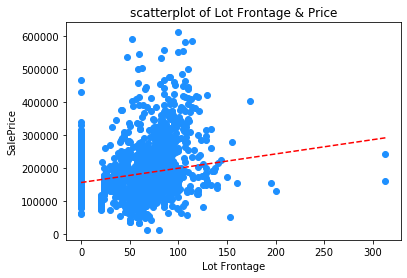

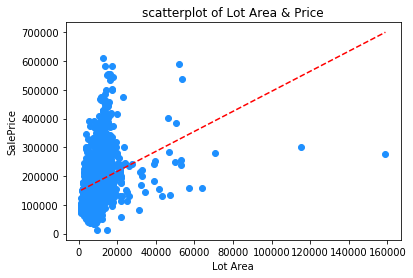

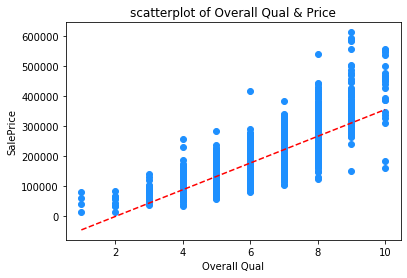

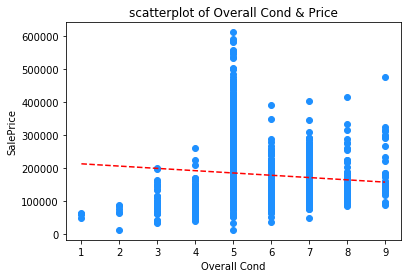

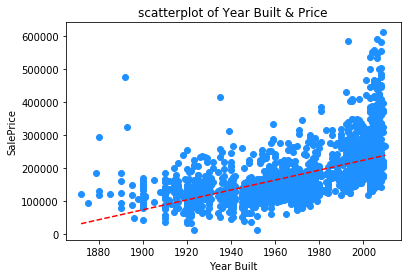

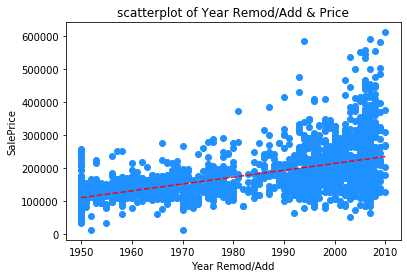

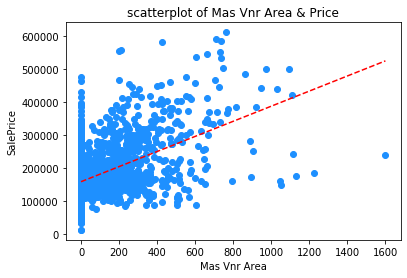

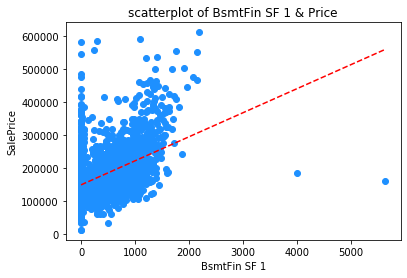

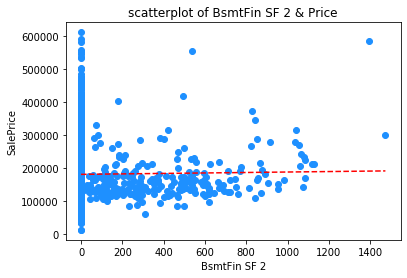

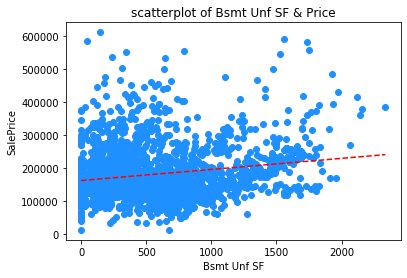

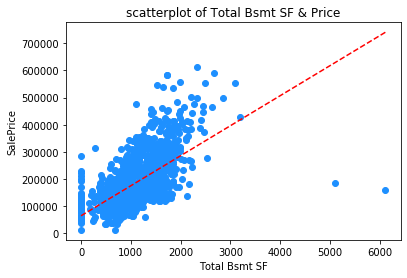

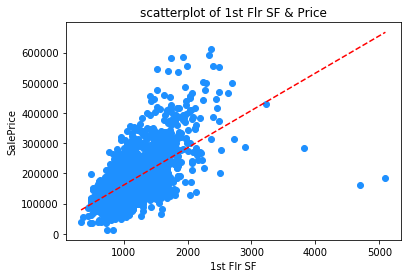

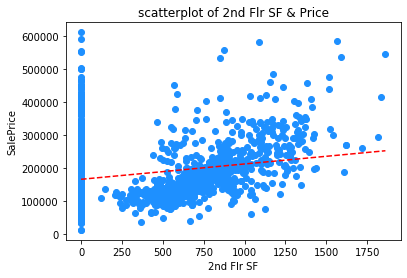

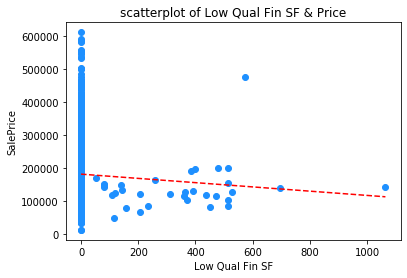

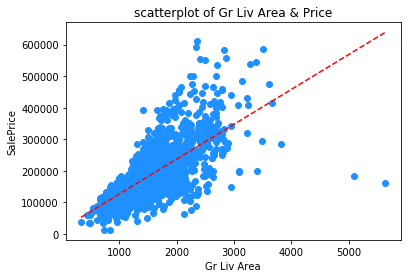

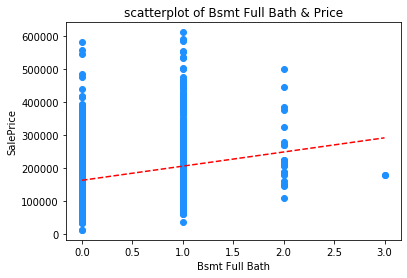

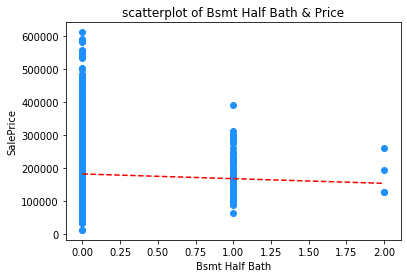

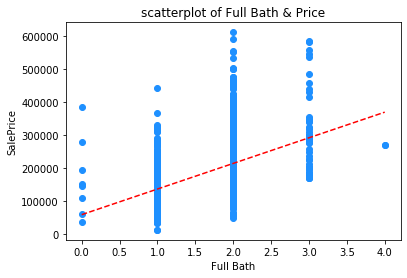

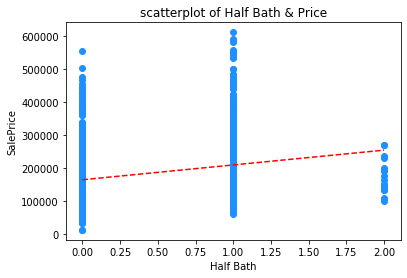

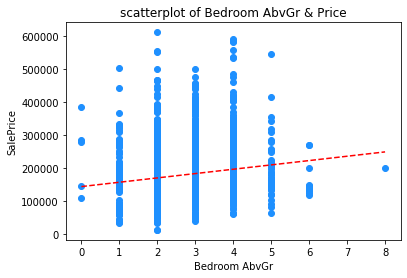

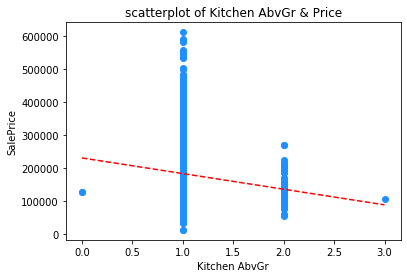

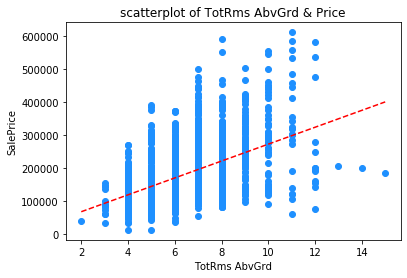

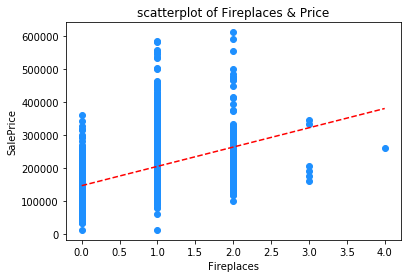

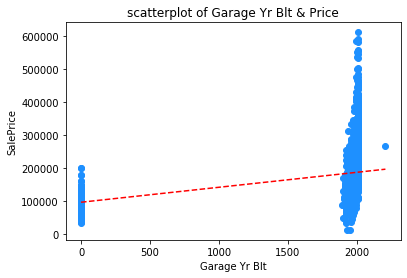

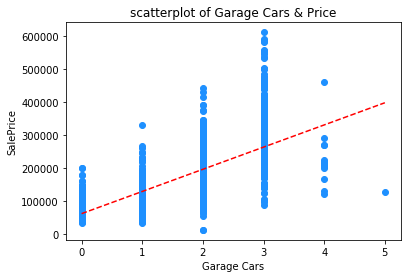

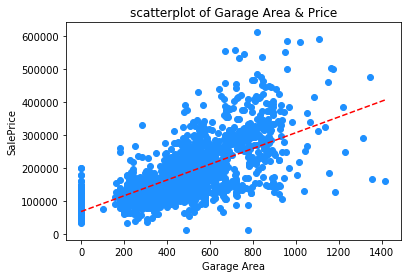

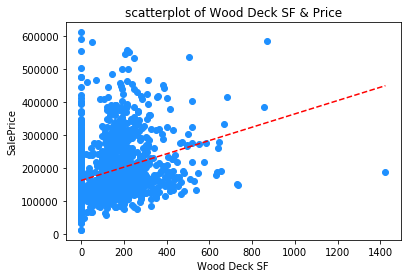

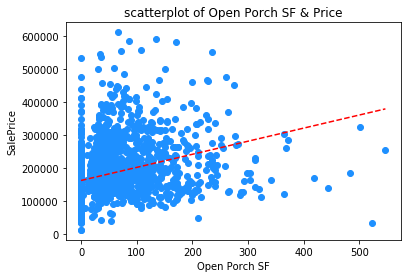

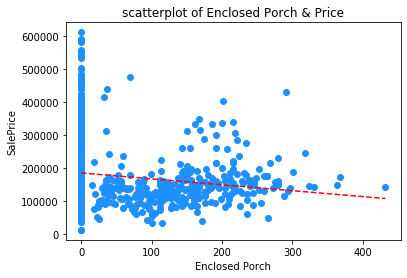

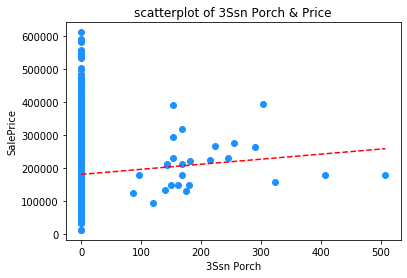

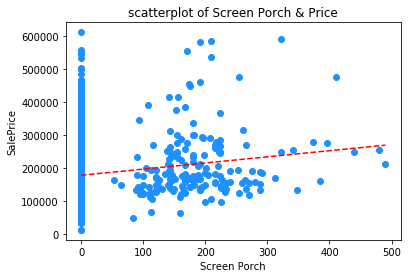

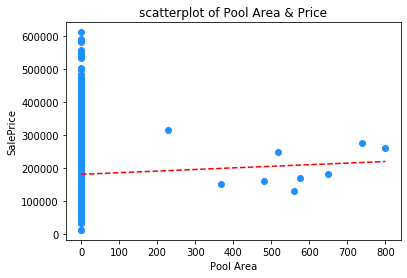

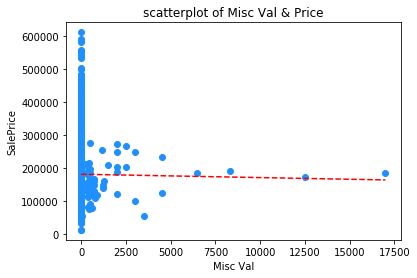

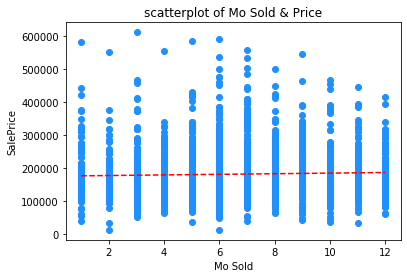

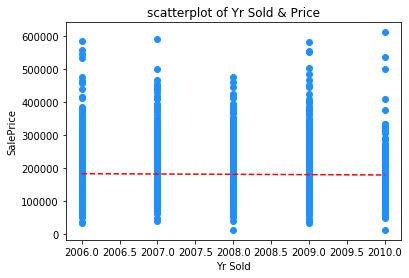

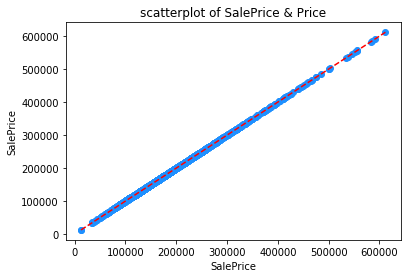

In [29]:
for i in train.select_dtypes(exclude='object').columns:
    plt.scatter(train[i], train['SalePrice'], color='dodgerblue')
    plt.plot(np.unique(train[i]), np.poly1d(np.polyfit(train[i], train['SalePrice'], 1))(np.unique(train[i])), 'r--')
    plt.title('scatterplot of ' + i + " & Price")
    plt.xlabel(i)
    plt.ylabel('SalePrice')
    plt.show()

#### Scatterplots

**For above numerical variables, the following seems to have a regressional relationship with price**
- `Lot Area` : there are 2 big outlier in lot area
- `Overall Qual`
- `Year Remod/Add` - higher val for recent builds
- `BsmtFin SF 1`: there are 2 big outlier
- `Total Bsmt SF`: there are 2 big outlier
- `1st Flr SF`: there are 2 big outlier
- `Gr Liv Area`: there are 2 big outlier
- `Full Bath`
- `TotRms AbvGrd`
- `Fireplaces`
- `Garage Cars`
- `Garage Area`

**Maybe**
<br>due to the fact that there are alot of zeros that is affecting - maybe good to do feature engineering to combine 1st Flr and 2nd Flr etc
- `2nd Flr SF` 
- `Bedroom AbvGr`
- `Wood Deck SF`
- `Open Porch SF`

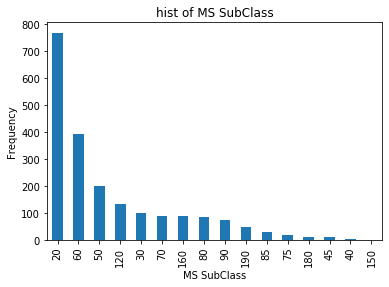

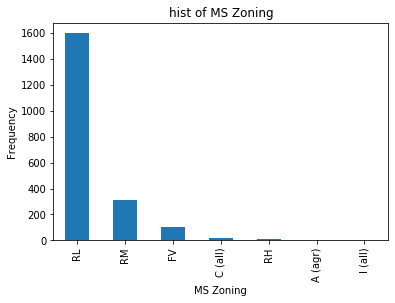

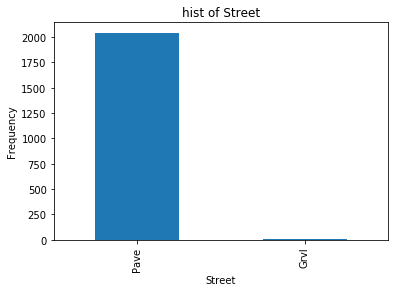

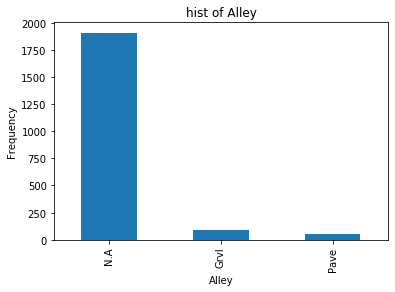

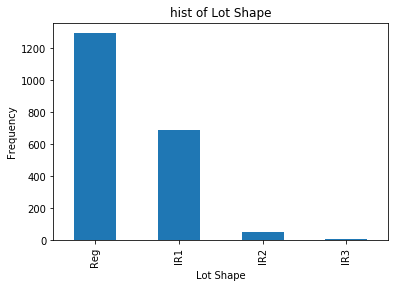

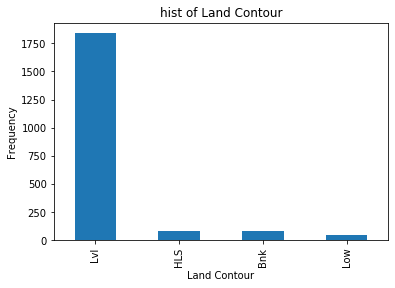

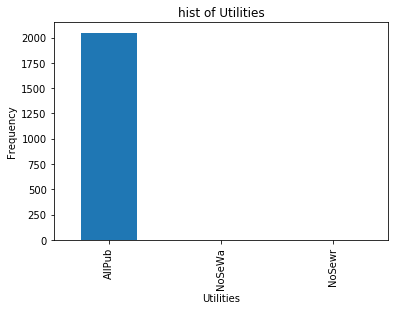

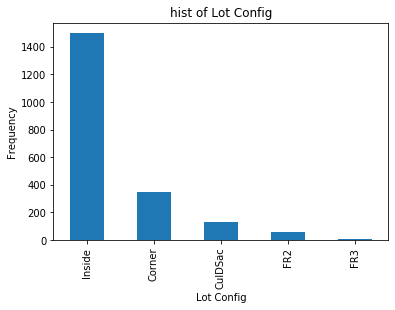

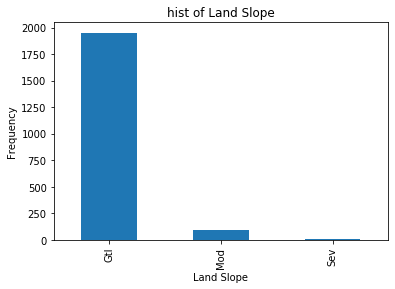

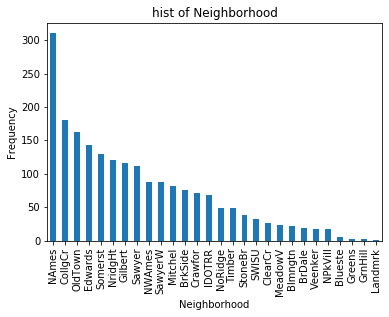

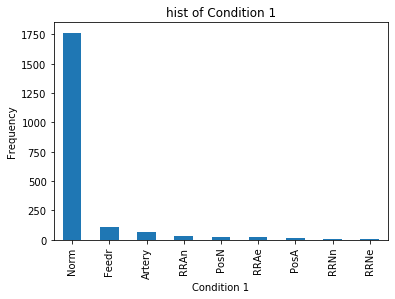

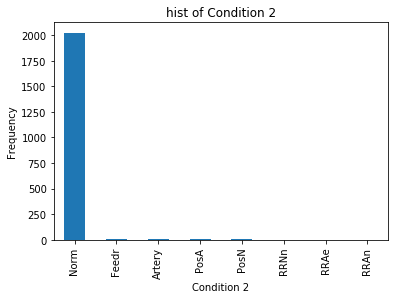

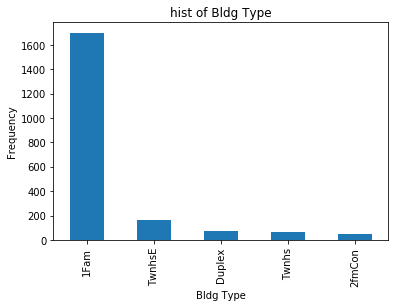

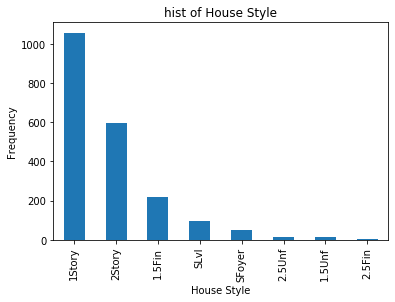

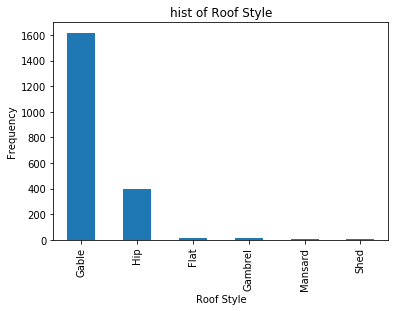

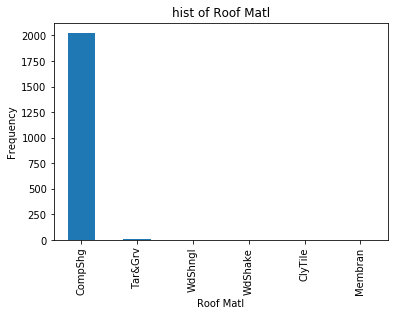

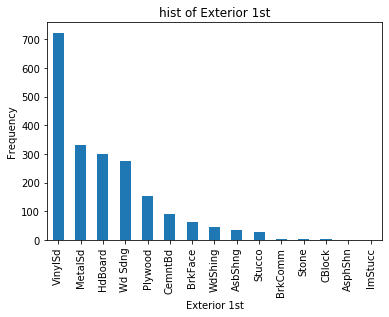

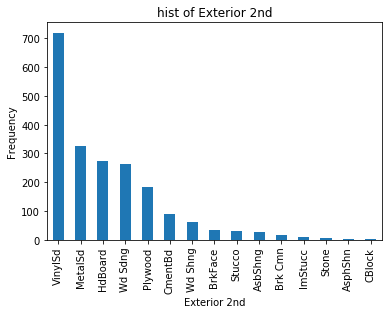

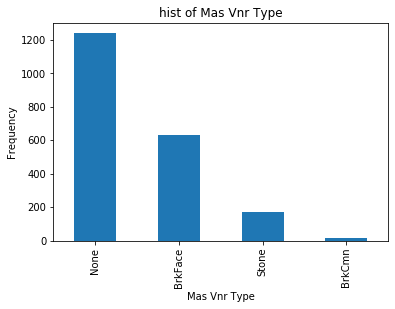

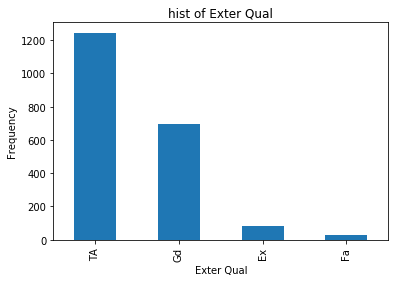

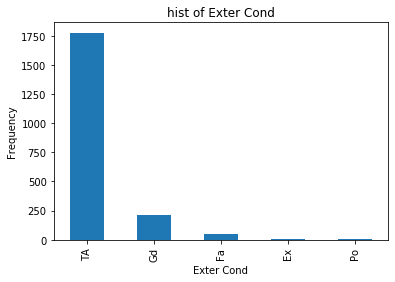

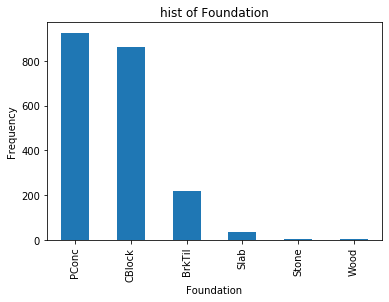

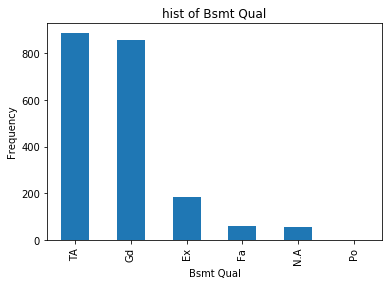

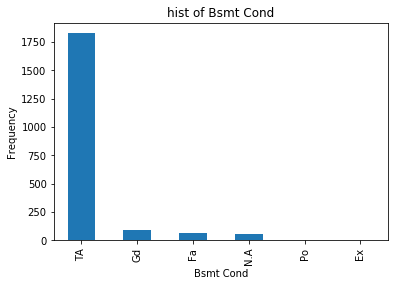

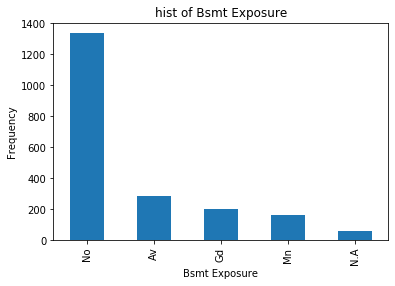

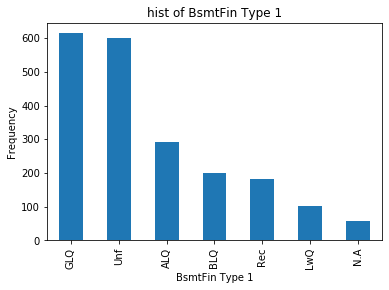

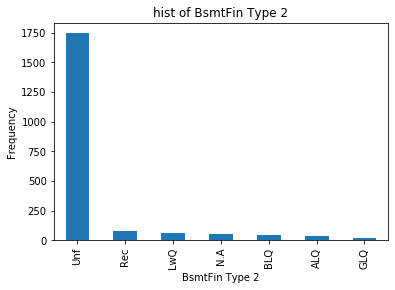

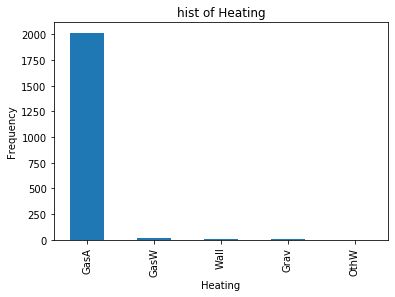

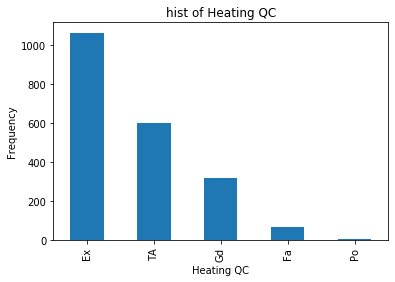

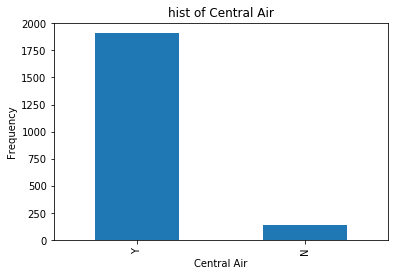

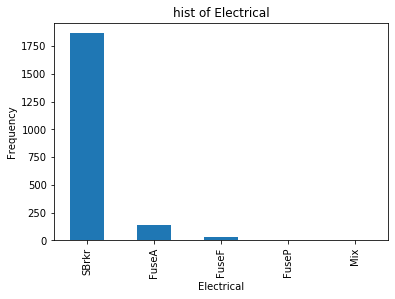

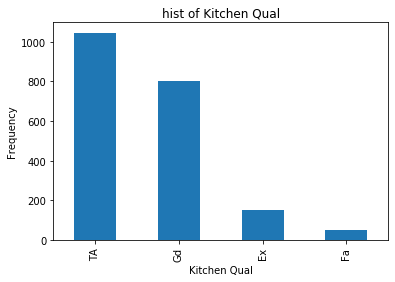

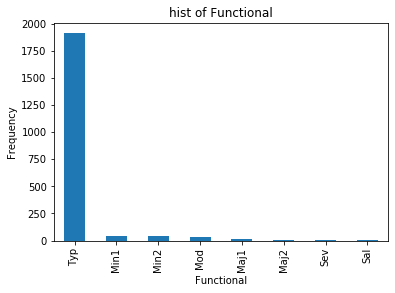

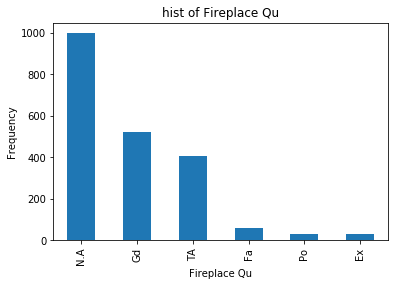

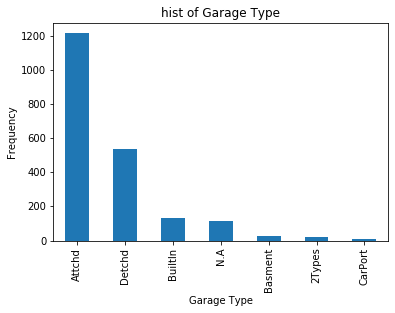

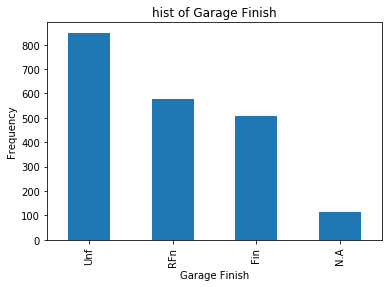

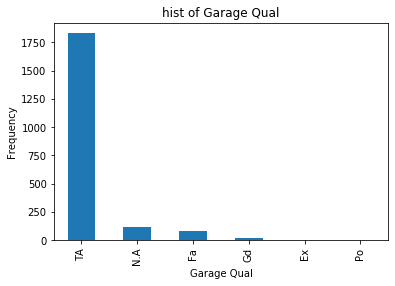

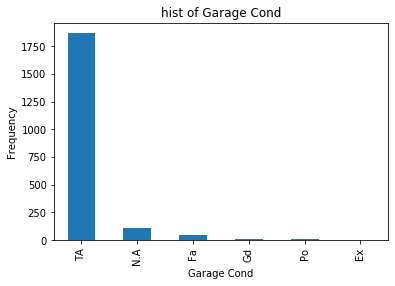

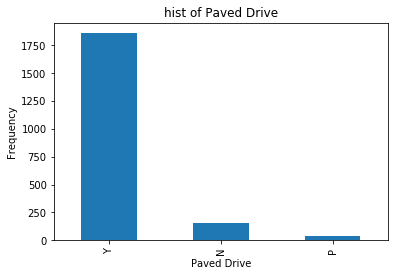

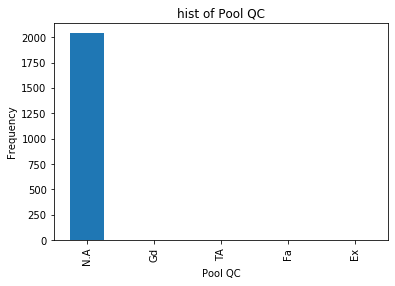

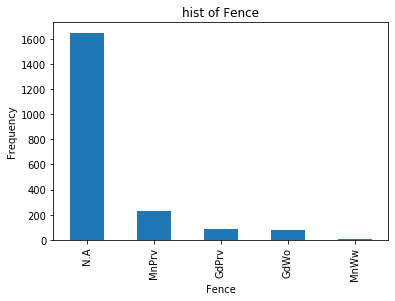

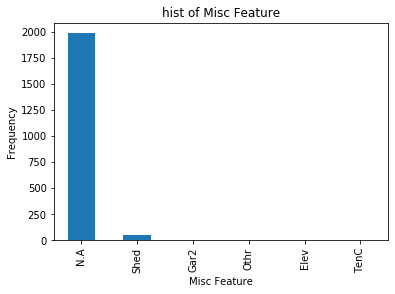

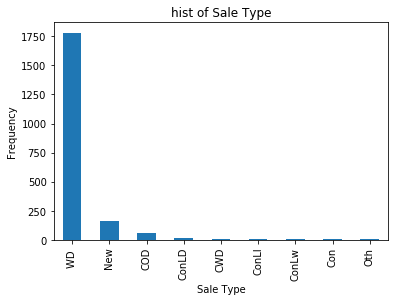

In [30]:
for i in train.select_dtypes(include='object').columns:
    train[i].value_counts().plot(kind='bar')
    plt.title('hist of ' + i)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()

In [31]:
train['Utilities'].value_counts()

AllPub    2047
NoSeWa       1
NoSewr       1
Name: Utilities, dtype: int64

#### Histogram

**Interpretation from Histogram plots**

Based on the histogram of the categorical features, there are alot of category where one of the features dominate. Ie `Utilities` there is only 1 instance where there is `NoSeWa` and another `NoSwer`. The model is unlikely to 'price' those features accurately.

<br>

C:\Users\himyn\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\himyn\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\himyn\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume 

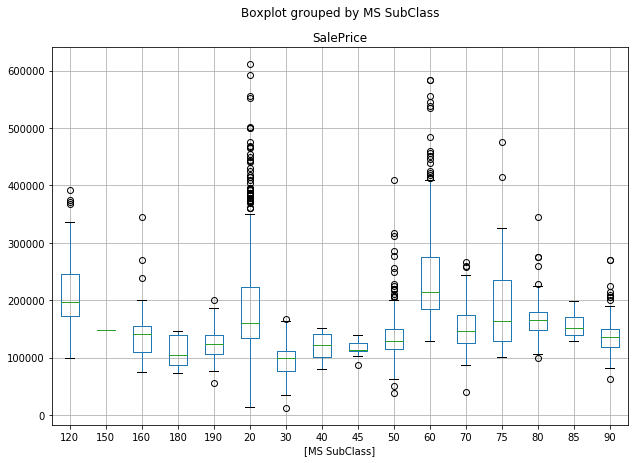

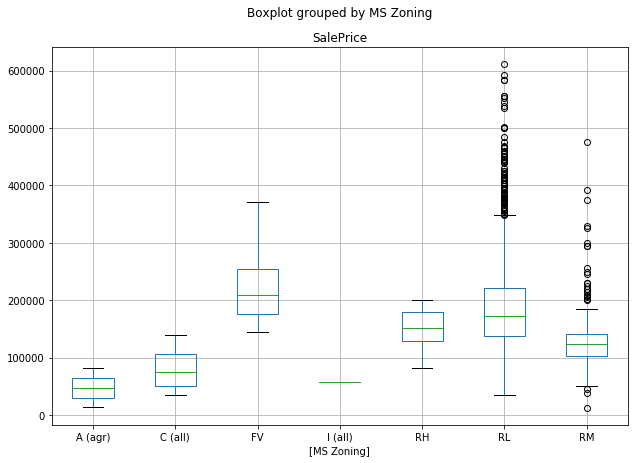

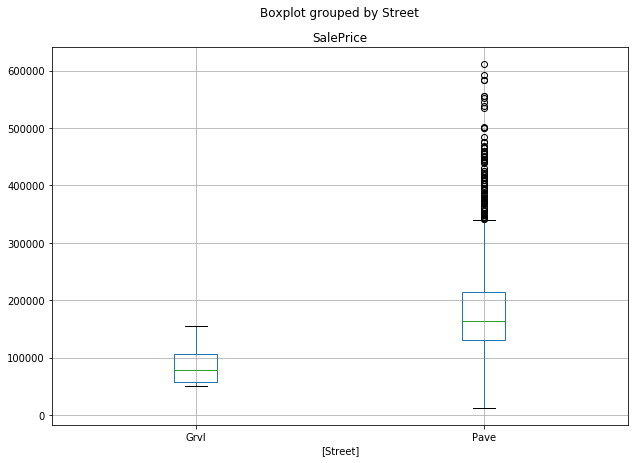

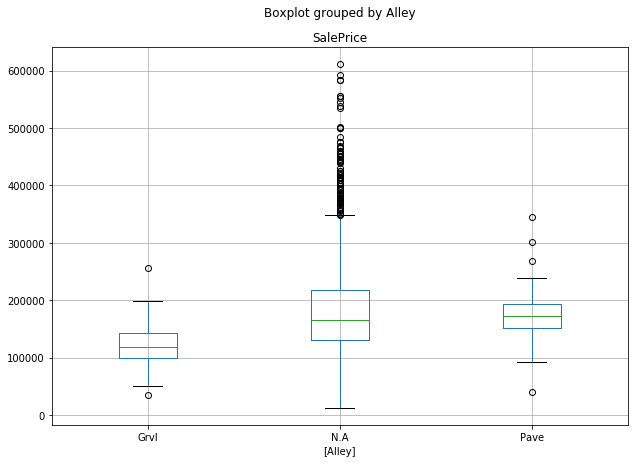

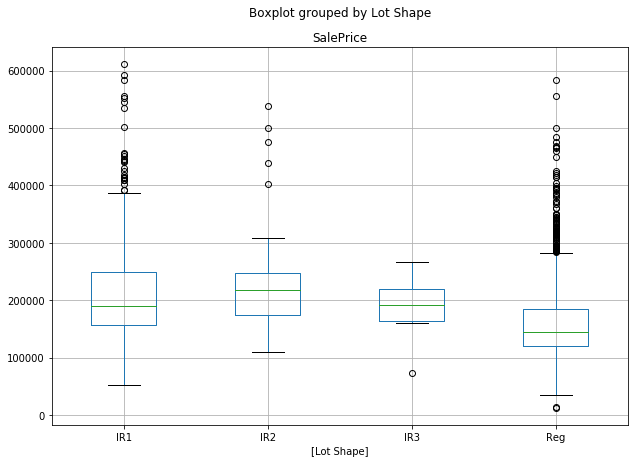

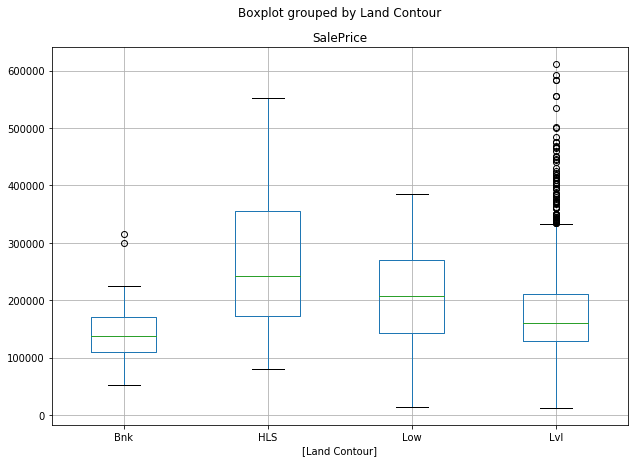

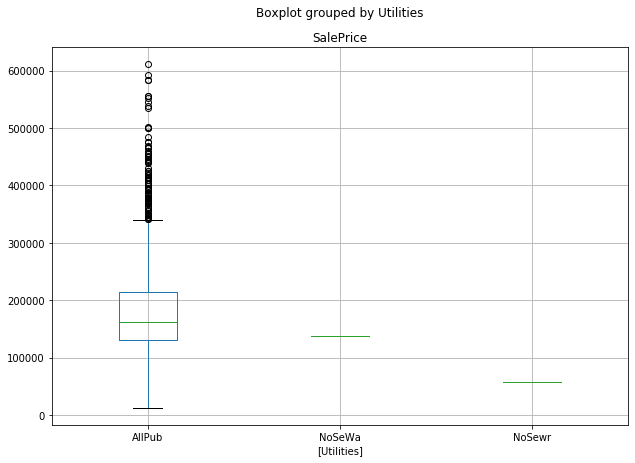

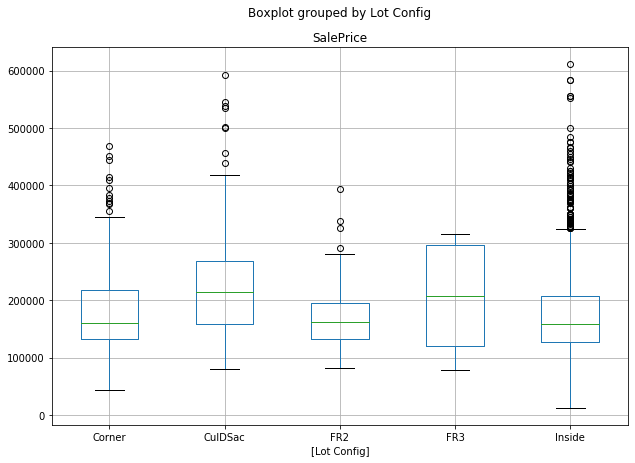

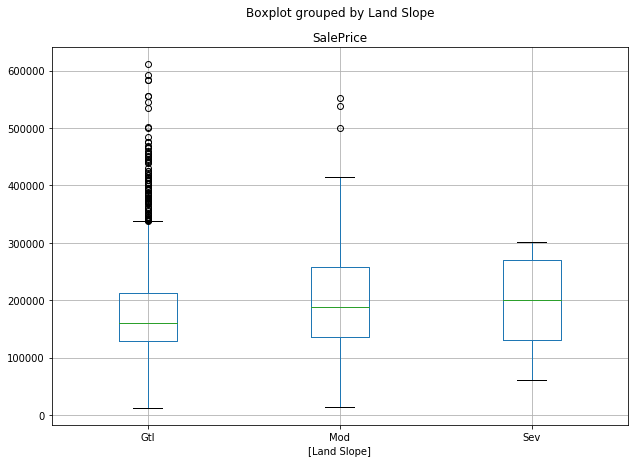

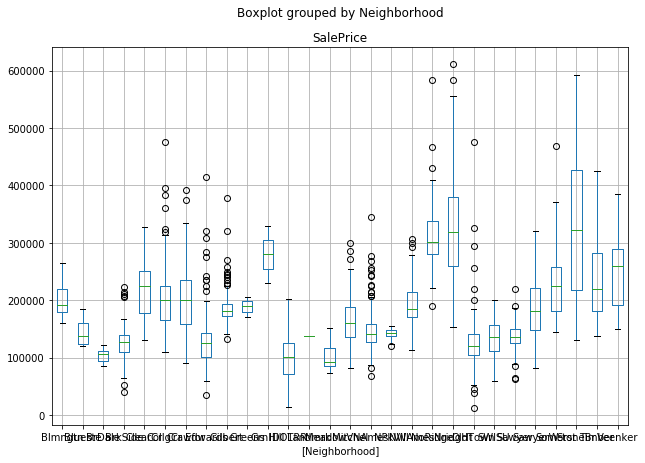

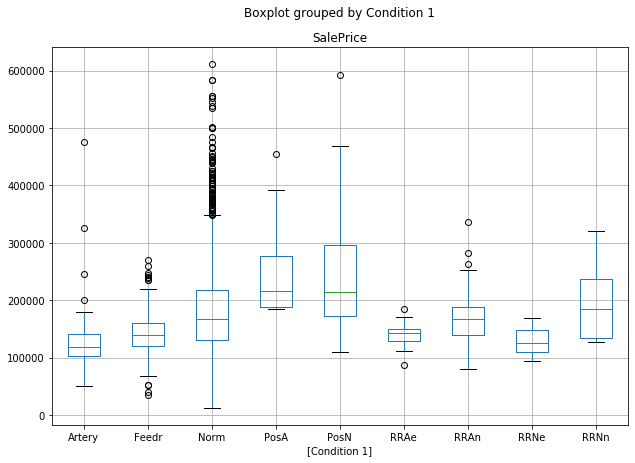

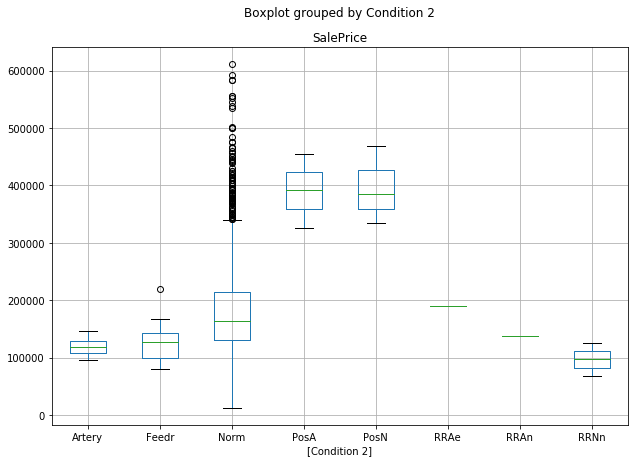

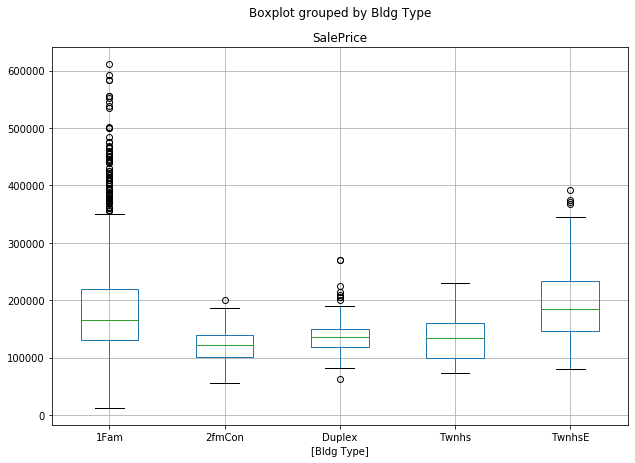

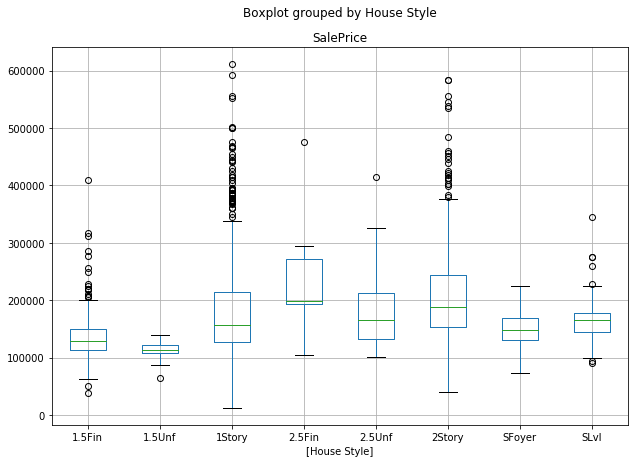

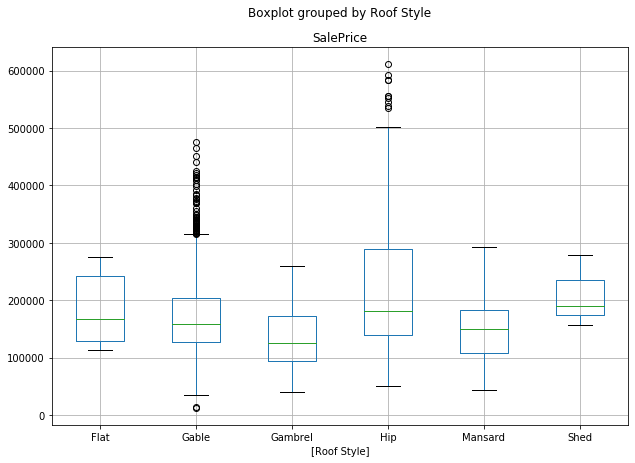

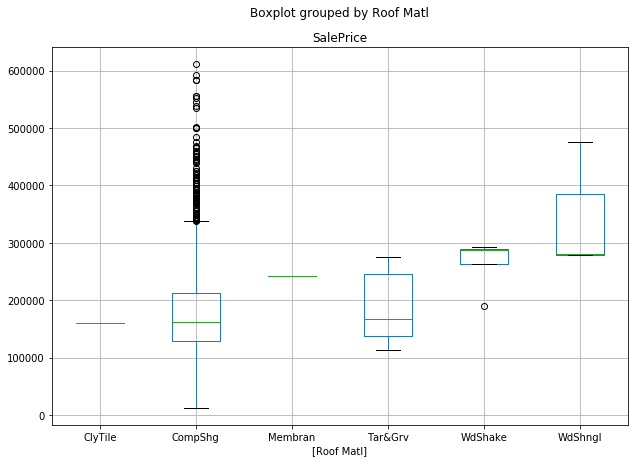

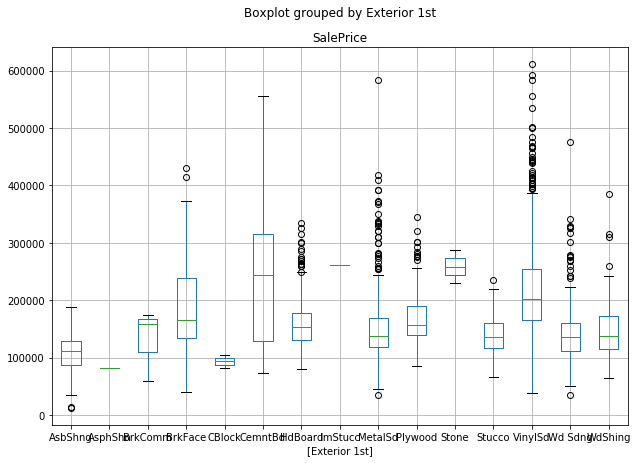

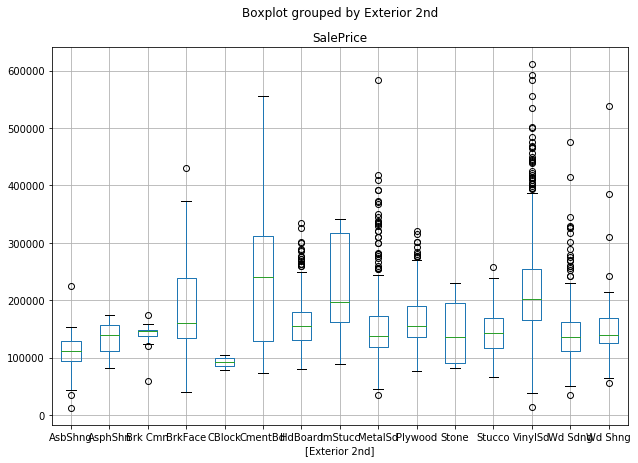

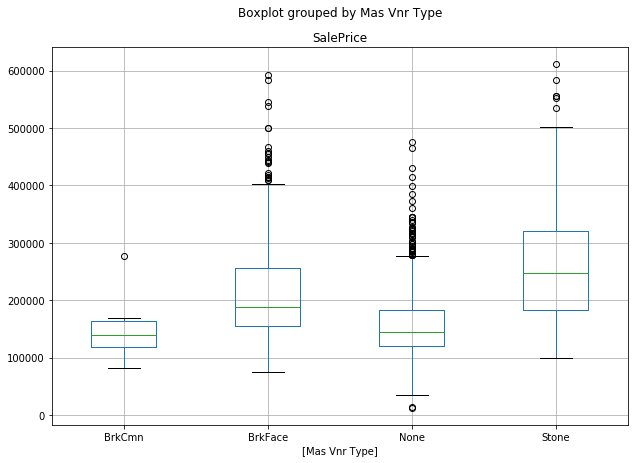

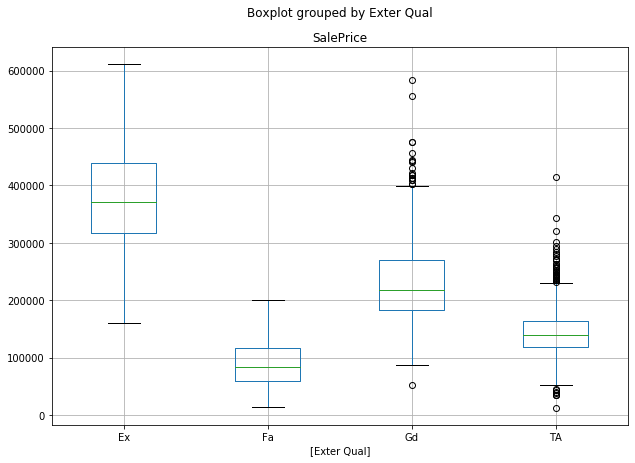

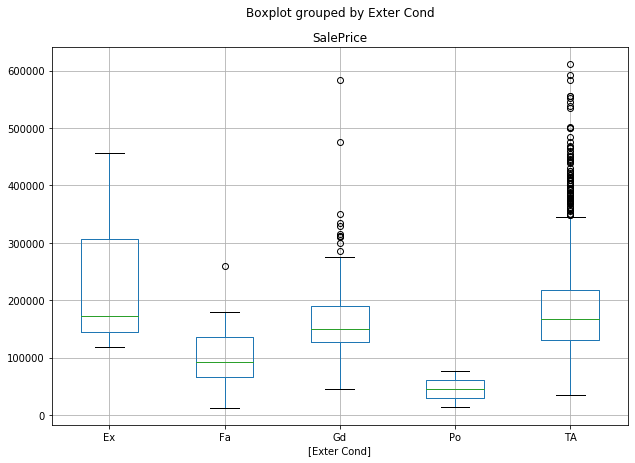

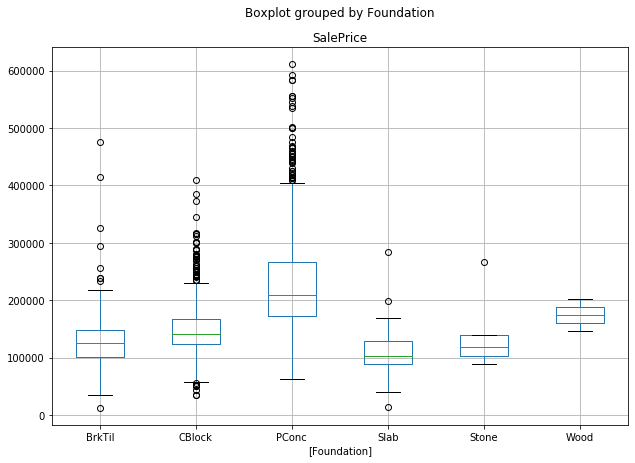

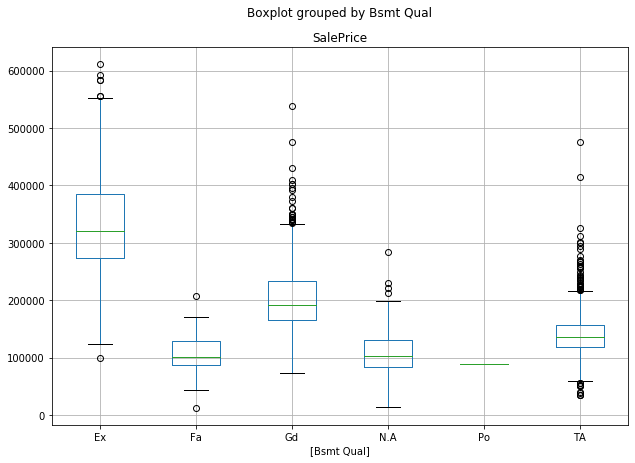

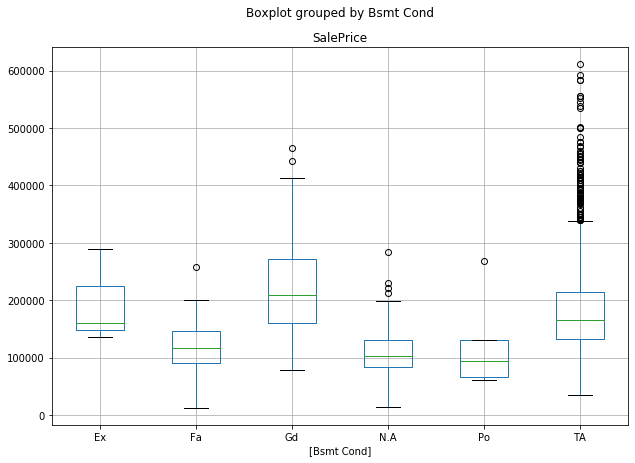

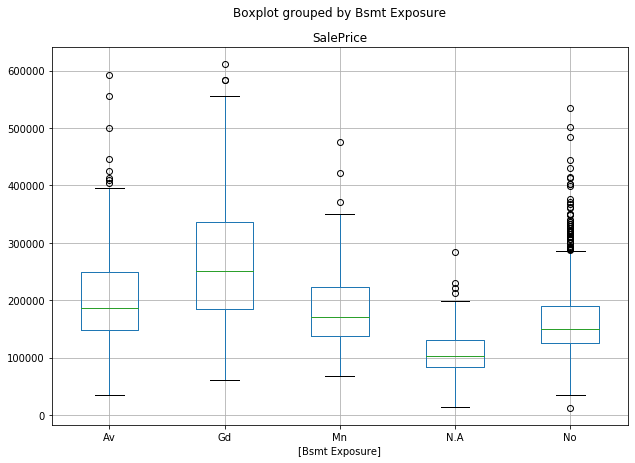

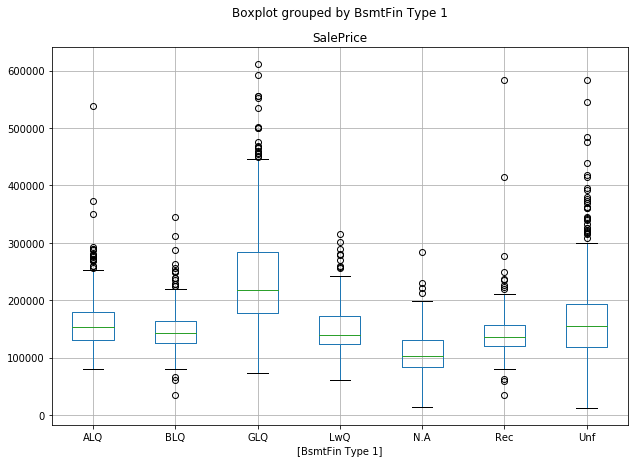

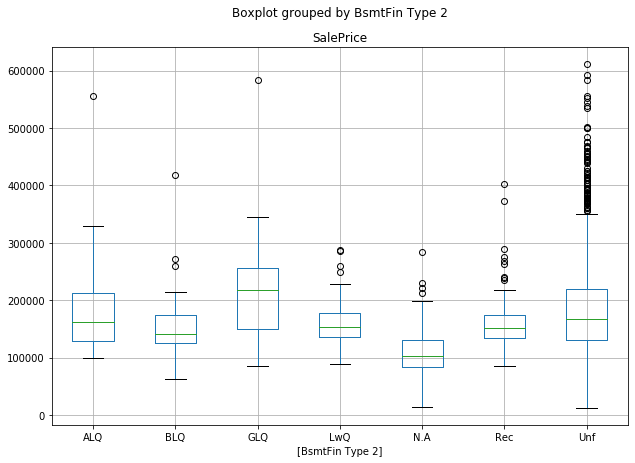

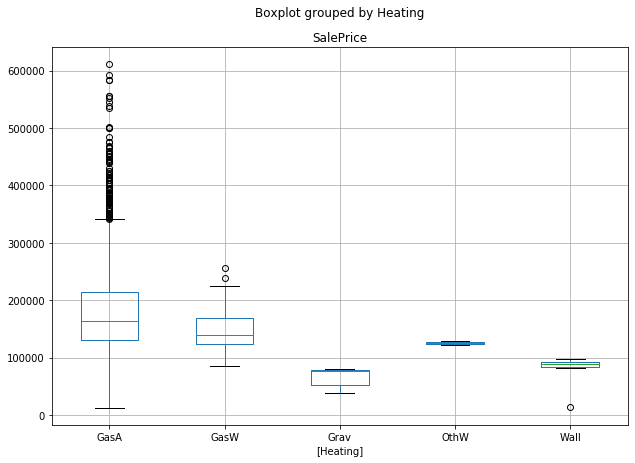

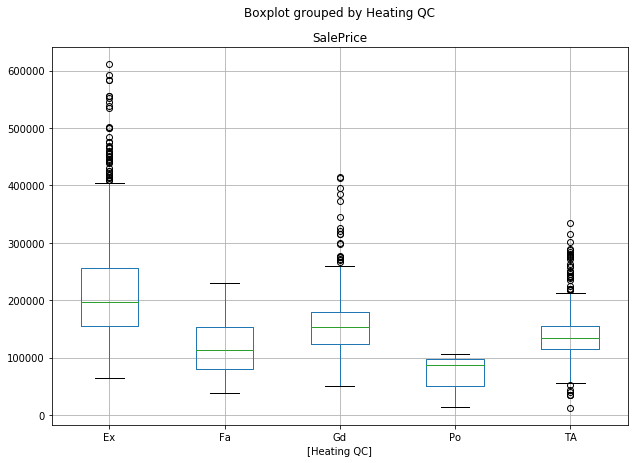

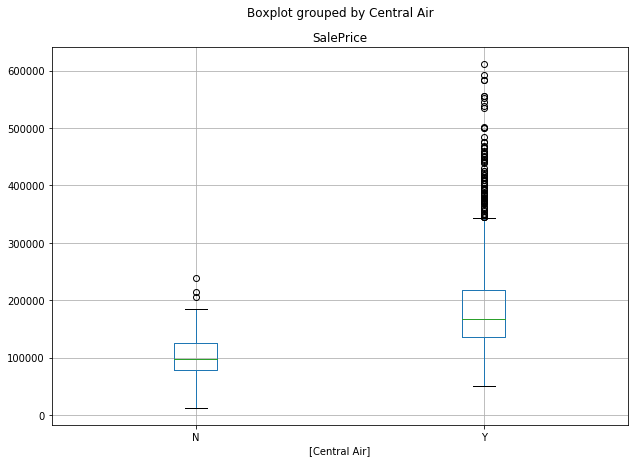

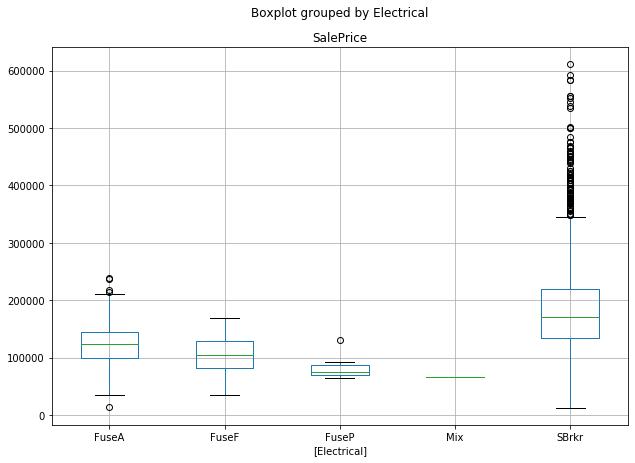

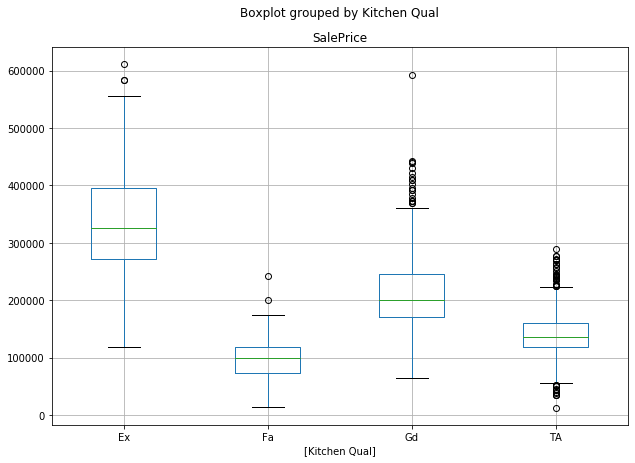

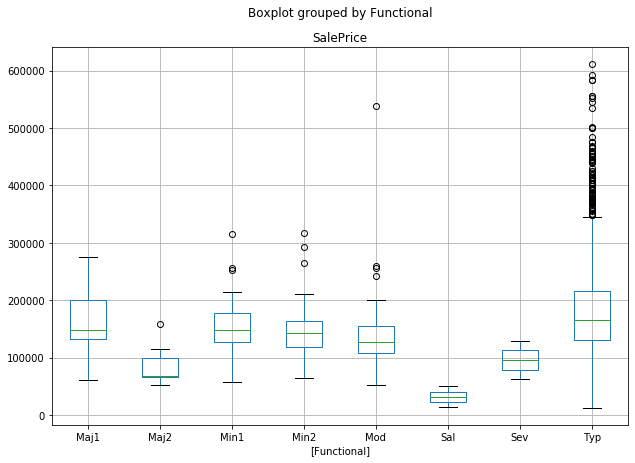

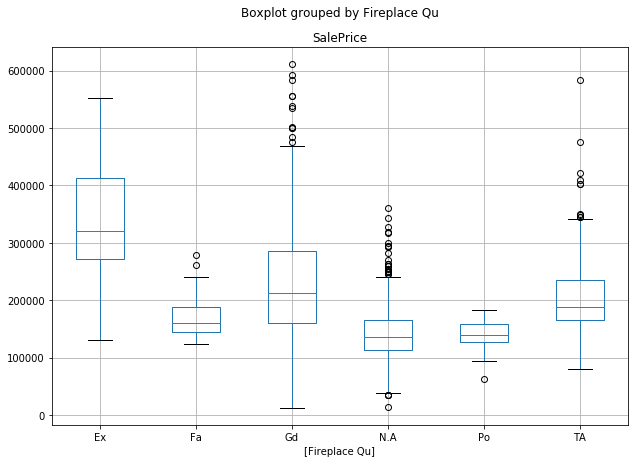

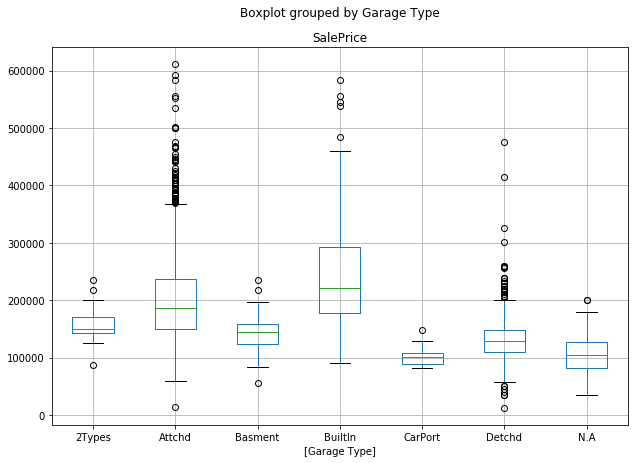

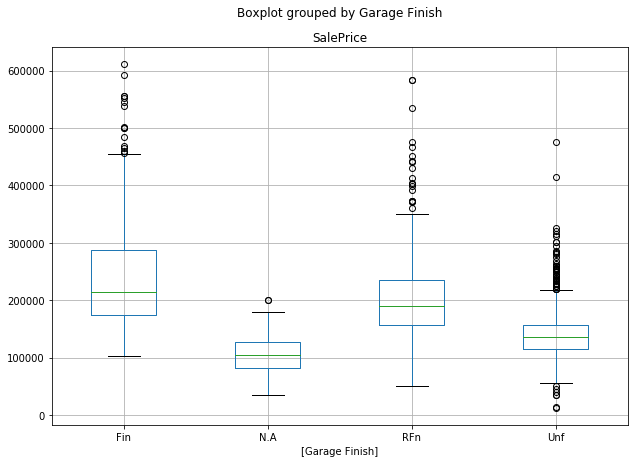

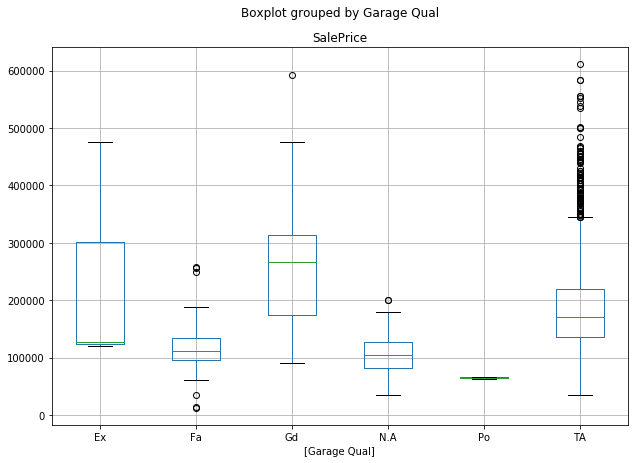

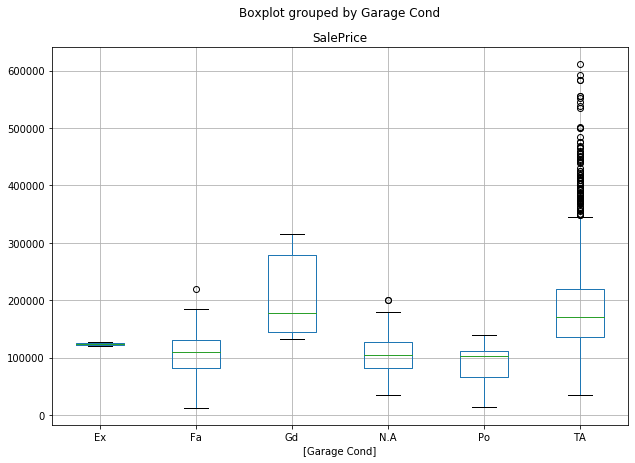

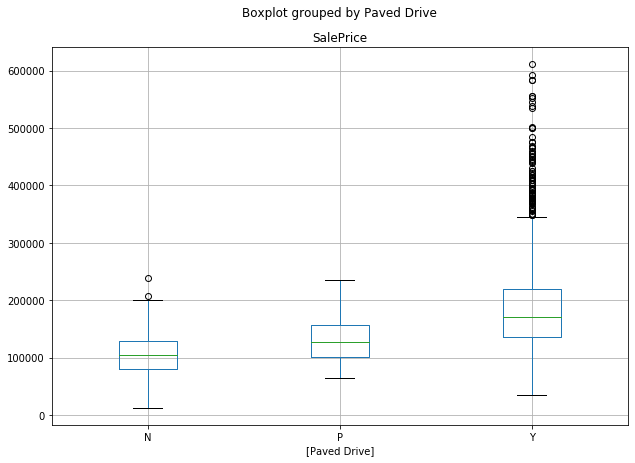

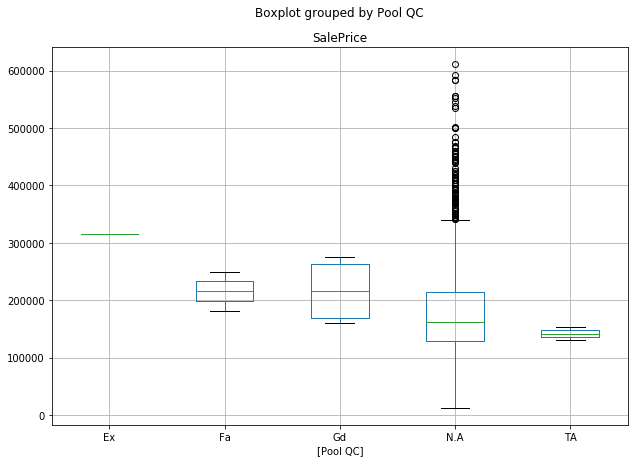

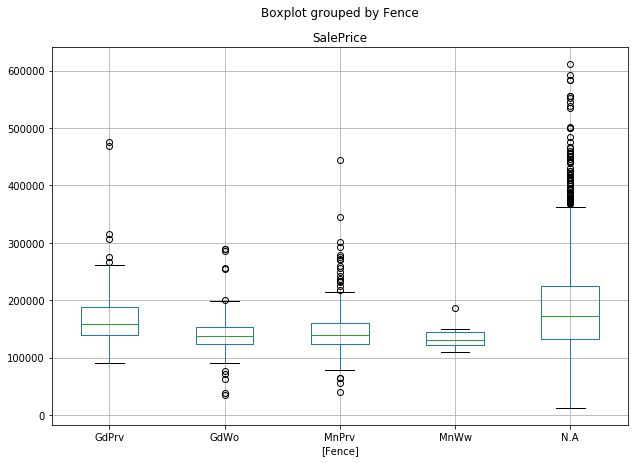

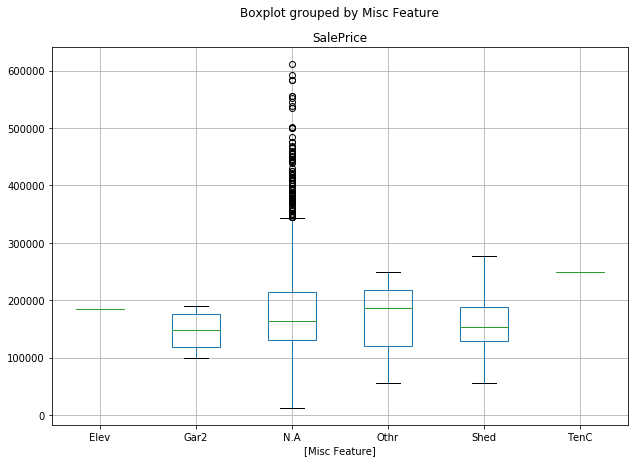

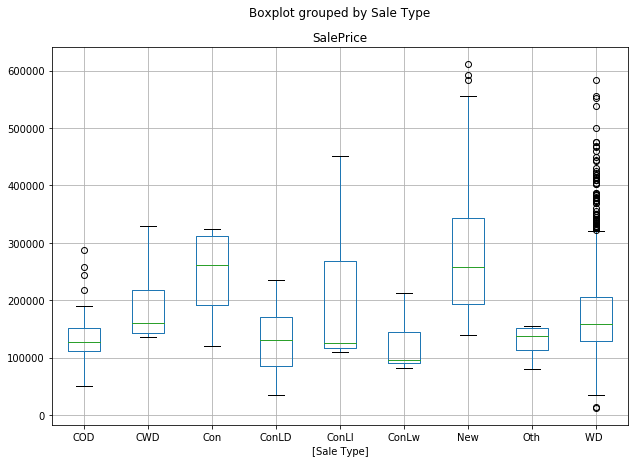

In [32]:
for i in train.select_dtypes(include='object').columns:
    train[[i,'SalePrice']].boxplot(by=i,figsize = (10,7))

#### Boxplot

I plot boxplot to see the rough spread of the data - the 25%,50%,75% percentile and the outliers and graphically a rough sensing on whether is there a obvious difference in the mean of the categories.
<br>
<br>
Can do ANOVA to be sure but not doing ANOVA here as I will be feeding all features into Lasso regression to do feature selection. The base model will be a naive model that most lay people on the street will use area of house. 
<br>
<br>


**Dropping the outlier data**

In [33]:
train[(train['Lot Area'] > 100000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2116,50,RL,0.0,159000,Pave,N.A,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.0,Unf,0.0,747.0,1444.0,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2.0,389.0,TA,TA,Y,0,98,0,0,0,0,N.A,N.A,Shed,500,6,2007,WD,277000
2072,20,RL,0.0,115149,Pave,N.A,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.0,Unf,0.0,424.0,1643.0,GasA,TA,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2.0,739.0,TA,TA,Y,380,48,0,0,0,0,N.A,N.A,N.A,0,6,2007,WD,302000


In [34]:
train[(train['Gr Liv Area'] > 5000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [35]:
train[(train['BsmtFin SF 1'] > 3500)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [36]:
train[(train['Total Bsmt SF'] > 4000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [37]:
train[(train['Wood Deck SF'] > 1400)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2294,80,RL,0.0,15957,Pave,N.A,IR1,Low,AllPub,Corner,Mod,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,1148.0,Unf,0.0,96.0,1244.0,GasA,TA,Y,SBrkr,1356,0,0,1356,2.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2.0,528.0,TA,TA,Y,1424,0,0,0,0,0,N.A,MnPrv,N.A,0,9,2007,WD,188000


In [38]:
train.drop(labels=[1499,2181,2116,2072,2294],inplace=True)

## Export a cleaned copy of the dataset before doing feature engineering/feature selection

In [39]:
train.to_csv('originalAMEScleaned.csv')

In [40]:
# rejig the positions of the columns.
cleantrain = train[['Lot Area', 'BsmtFin SF 1','1st Flr SF','2nd Flr SF', 'Gr Liv Area','Total Bsmt SF','Wood Deck SF', 'Open Porch SF','Garage Area',
                    'Year Remod/Add','Overall Qual', 'Exter Qual','Bsmt Qual','Bsmt Exposure','BsmtFin Type 1', 'Heating QC', 'Kitchen Qual','Fireplace Qu',
                    'Full Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Fireplaces',  'Garage Cars', 'MS SubClass','Land Contour', 'Neighborhood','House Style','Exterior 1st', 'Exterior 2nd','Foundation','Garage Type','Garage Finish','SalePrice']].copy()

In [41]:
# permutating counts of areas
cleantrain['corearea12F_TBsmt'] = cleantrain['1st Flr SF'] + cleantrain['2nd Flr SF'] + cleantrain['Total Bsmt SF']
cleantrain['coreareaGrliv_BsmtF'] = cleantrain['Gr Liv Area'] + cleantrain['BsmtFin SF 1']
cleantrain['All12F'] = cleantrain['1st Flr SF'] + cleantrain['2nd Flr SF'] + cleantrain['Total Bsmt SF'] + cleantrain['Wood Deck SF'] + cleantrain['Open Porch SF'] + cleantrain['Garage Area']
cleantrain['AllGrliv'] = cleantrain['Gr Liv Area'] + cleantrain['BsmtFin SF 1'] + cleantrain['Wood Deck SF'] + cleantrain['Open Porch SF'] + cleantrain['Garage Area']

# age of remodelled house
cleantrain['age'] = 2010 - cleantrain['Year Remod/Add']

In [42]:
quality = ['Exter Qual','Bsmt Qual','Heating QC', 'Kitchen Qual','Fireplace Qu']

#created a loop to map all the ranking into ordinal
for i in quality:
    cleantrain[i] = cleantrain[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'N.A':0})

In [43]:
# map into ordinal
cleantrain['BsmtFin Type 1'] = cleantrain['BsmtFin Type 1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'N.A':0})
cleantrain['Bsmt Exposure'] = cleantrain['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'N.A':0})

<a id='5.-Baseline-model-creation'></a>
# 5. Baseline model creation

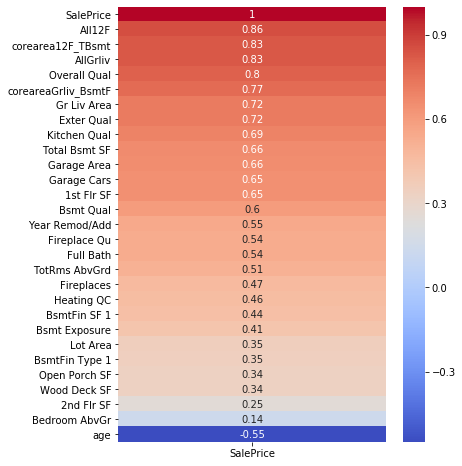

In [44]:
plt.figure(figsize=(6,8))
sns.heatmap(cleantrain.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False),annot=True,cmap='coolwarm')

`All12F` has very high correlation to `Price` and most of the other features with the exception `age` which is negatively correlated to `Price`.

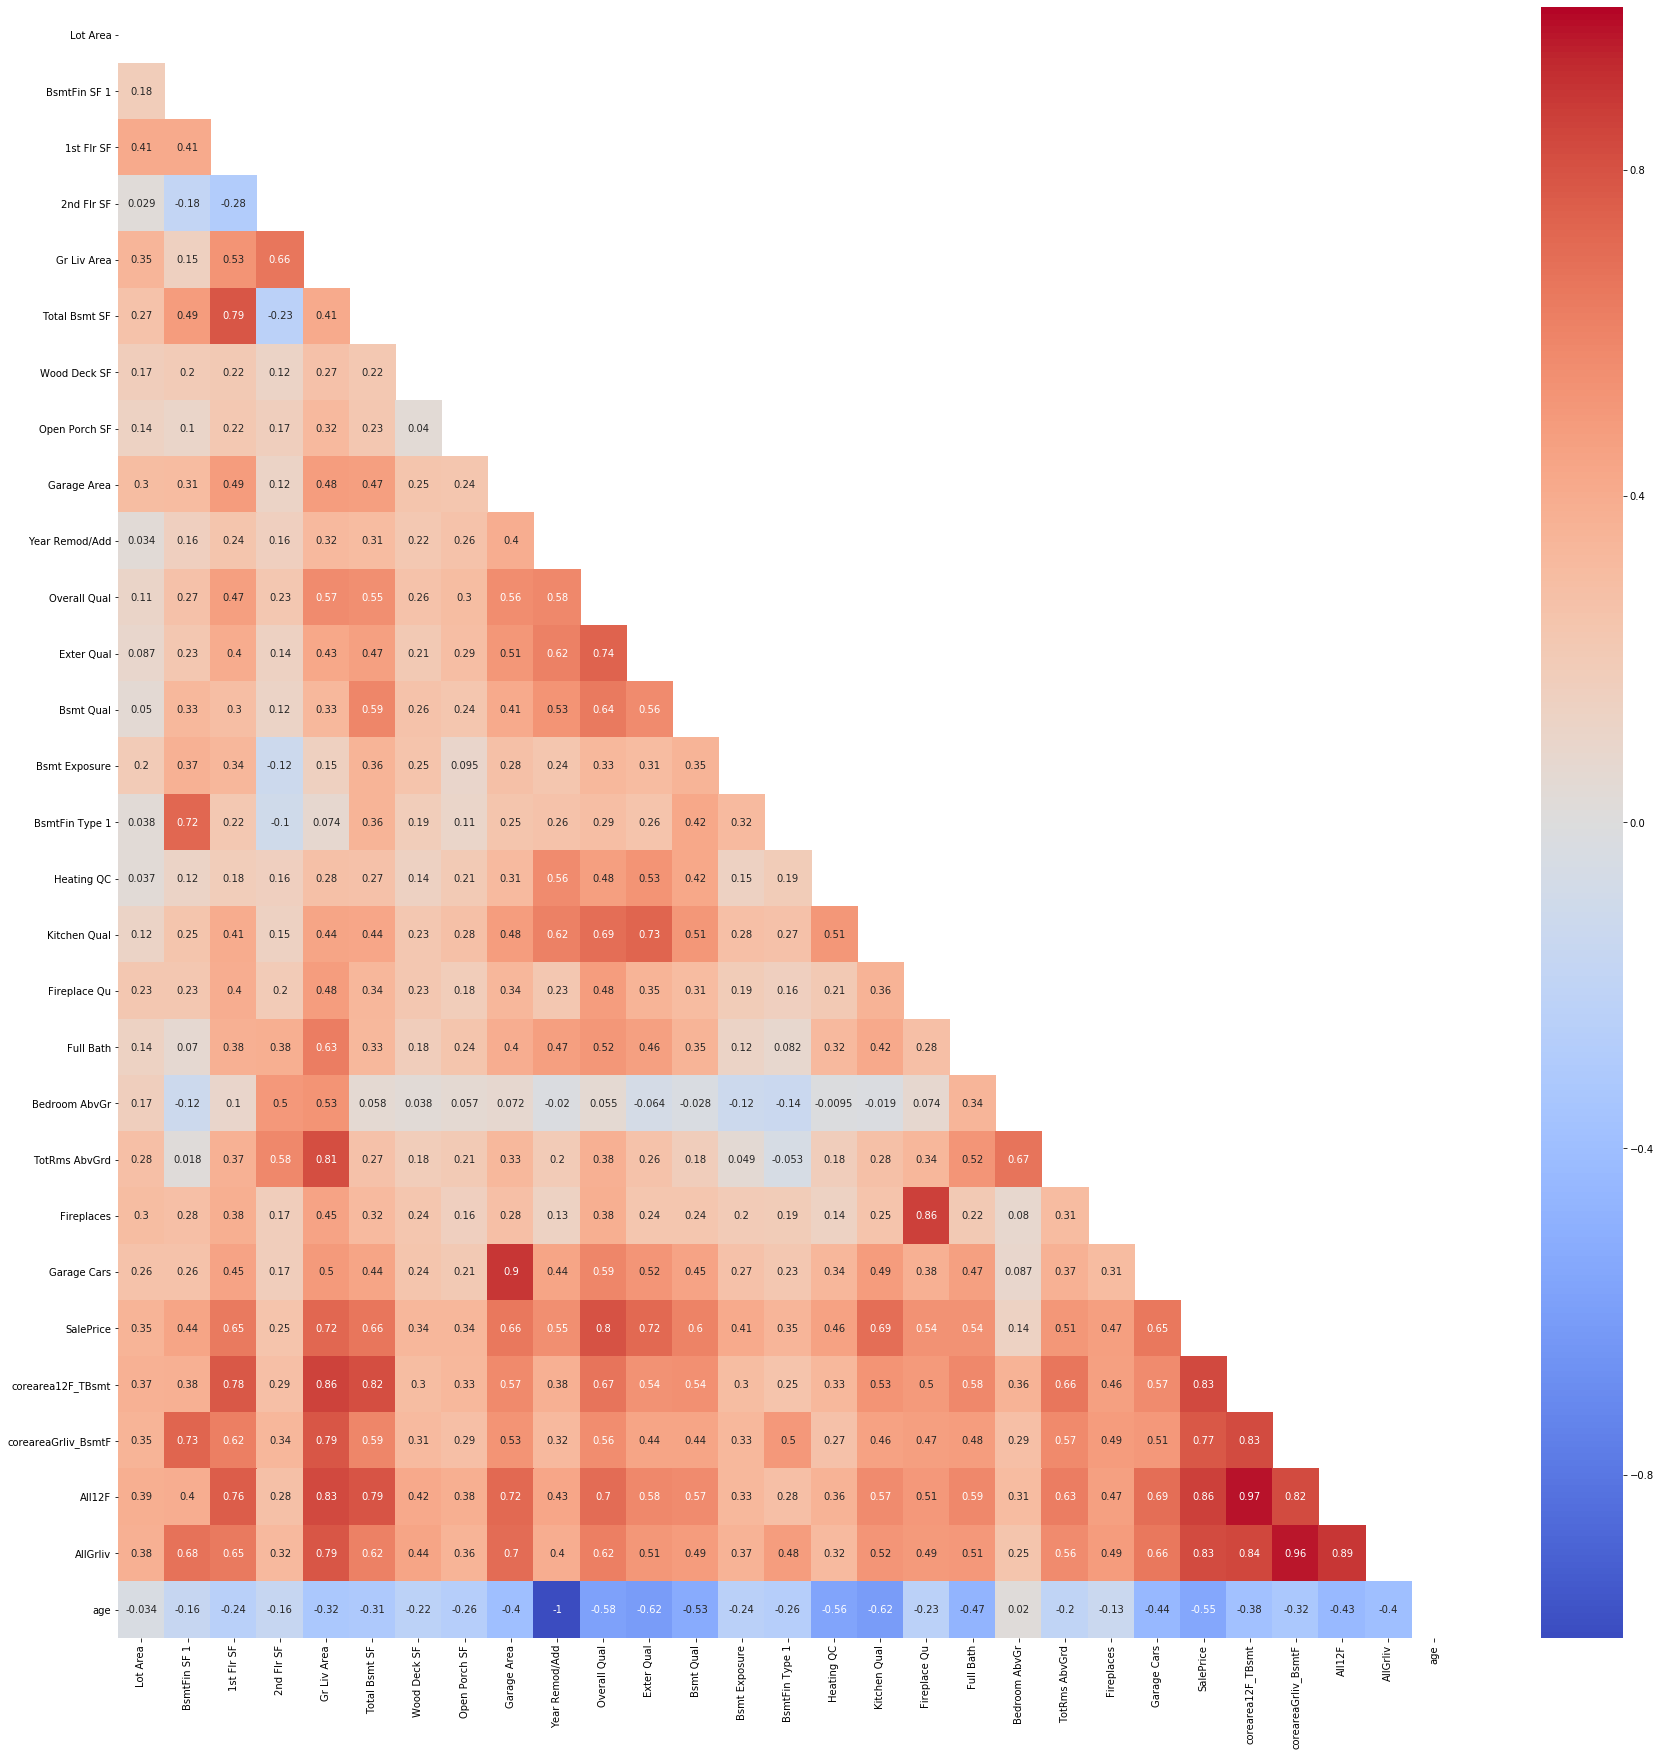

In [45]:
mask = np.zeros_like(cleantrain.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,30))
sns.heatmap(cleantrain.corr(),annot=True,mask=mask, cmap='coolwarm')

Plotted the whole heatmap to see cross-correlations of the feature. 

Our top `All12F` has high correlation to alot of the other features because it is a blend of most of the Area related data.

## Our baseline: Single Linear Regressor

In [46]:
X = cleantrain['All12F'].values.reshape(-1,1)
y = cleantrain['SalePrice']

In [47]:
# use the default .25
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [48]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [49]:
lr = LinearRegression()

In [50]:
lr_scores = cross_val_score(lr,X_train_sc,y_train,cv=5)
lr_scores.mean()

0.7386424371373101

**Our baseline SLR has a r2 of ~0.74. You might not see it as 0.74 when you run the notebook due to the random shuffling in cross validation**

In [51]:
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
y_pred = lr.predict(X_test_sc)

In [53]:
lr.score(X_test_sc,y_test)

0.738266610941718

In [54]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 28461.187049368677
Root Mean Squared Error: 42531.99628587381


<a id='6.-Our-simple-3-variable-Multi-Linear-Regressor'></a>
## 6. Our simple 3 variable Multi Linear Regressor

Using `All12F`,`Overall Qual` & `age` based on correlation heatmap.

In [55]:
X = cleantrain[['All12F','Overall Qual','age']]
y = cleantrain['SalePrice']

In [56]:
X.shape

(2044, 3)

In [57]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [58]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [59]:
lr_scores = cross_val_score(lr,X_train_sc,y_train,cv=5)
lr_scores.mean()

0.8254644208482034

In [60]:
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
r2 = lr.score(X_test_sc, y_test)
r2

0.8260170943501547

In [62]:
y_pred = lr.predict(X_test_sc)

In [63]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 24179.901137475652
Root Mean Squared Error: 35116.03950858926


In [64]:
Adj_r2 = 1-(1-r2)*(2044-1)/(2044-3-1)

Adj_r2

0.8257612371359637

<a id='7.-Embedded-method-of-feature-selection'></a>
## 7. Embedded method of feature selection

**One hot encoding to get all the rest of categorical features in**

In [65]:
final = pd.get_dummies(cleantrain,drop_first=True)

In [66]:
final.shape

(2044, 123)

### Use the below code to remove low variance features

In [67]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [68]:
droppedfinal = variance_threshold_selector(final, threshold=0.05)

In [69]:
droppedfinal.shape

(2044, 62)

In [70]:
droppedfinal.columns

Index(['Lot Area', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Total Bsmt SF', 'Wood Deck SF', 'Open Porch SF', 'Garage Area',
       'Year Remod/Add', 'Overall Qual', 'Exter Qual', 'Bsmt Qual',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Kitchen Qual',
       'Fireplace Qu', 'Full Bath', 'Bedroom AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'SalePrice', 'corearea12F_TBsmt',
       'coreareaGrliv_BsmtF', 'All12F', 'AllGrliv', 'age', 'MS SubClass_20',
       'MS SubClass_50', 'MS SubClass_60', 'Land Contour_Lvl',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_Somerst', 'House Style_1Story',
       'House Style_2Story', 'Exterior 1st_HdBoard', 'Exterior 1st_MetalSd',
       'Exterior 1st_Plywood', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng',
       'Exterior 2nd_HdBoard', 'Exterior 2

**122 -> 62 drops half of the features**

In [71]:
features = [col for col in droppedfinal.columns if col != 'SalePrice']
X = droppedfinal[features]
y = droppedfinal['SalePrice']

In [72]:
X.head()

,Lot Area,BsmtFin SF 1,1st Flr SF,2nd Flr SF,Gr Liv Area,Total Bsmt SF,Wood Deck SF,Open Porch SF,Garage Area,Year Remod/Add,Overall Qual,Exter Qual,Bsmt Qual,Bsmt Exposure,BsmtFin Type 1,Heating QC,Kitchen Qual,Fireplace Qu,Full Bath,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,corearea12F_TBsmt,coreareaGrliv_BsmtF,All12F,AllGrliv,age,MS SubClass_20,MS SubClass_50,MS SubClass_60,Land Contour_Lvl,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,House Style_1Story,House Style_2Story,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 2nd_HdBoard,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,Garage Type_Attchd,Garage Type_BuiltIn,Garage Type_Detchd,Garage Type_N.A,Garage Finish_N.A,Garage Finish_RFn,Garage Finish_Unf
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,13517,533.0,725,754,1479,725.0,0,44,475.0,2005,6,4,3,0,6,5,4,0,2,3,6,0,2.0,2204.0,2012.0,2723.0,2531.0,5,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
544,11492,637.0,913,1209,2122,913.0,0,74,559.0,1997,7,4,4,0,6,5,4,3,2,4,8,1,2.0,3035.0,2759.0,3668.0,3392.0,13,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
153,7922,731.0,1057,0,1057,1057.0,0,52,246.0,2007,5,3,3,0,6,3,4,0,1,3,5,0,1.0,2114.0,1788.0,2412.0,2086.0,3,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
318,9802,0.0,744,700,1444,384.0,100,0,400.0,2007,5,3,4,0,1,4,3,0,2,3,7,0,2.0,1828.0,1444.0,2328.0,1944.0,3,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
255,14235,0.0,831,614,1445,676.0,0,59,484.0,1993,6,3,2,0,1,3,3,0,2,3,6,0,2.0,2121.0,1445.0,2664.0,1988.0,17,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [73]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [74]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Intutively use  Lasso Regression for feature selection to force drop features

In [75]:
optimal_lasso = LassoCV(n_alphas=200, cv=10)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

81.73478373007505


C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1316812601.4588623, tolerance: 972476104.4943715
  positive)


In [76]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149975470.05188, tolerance: 865669892.6672746
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207367226.369385, tolerance: 890279781.7525527
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2540607485.1835938, tolerance: 861276602.2469304
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

[0.8925186  0.91262642 0.91008365 0.84799679 0.88844146 0.89694763
 0.89631501 0.87863032 0.89404513 0.81800609]
0.8835611089452524


C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 930082338.5350342, tolerance: 849717698.9865516
  positive)


In [77]:
lasso.fit(X_train_sc,y_train)

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1316812601.4588623, tolerance: 972476104.4943715
  positive)


Lasso(alpha=81.73478373007505, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
y_pred = lasso.predict(X_test_sc)

In [79]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 18443.171718449506
Root Mean Squared Error: 25335.408176553734


In [80]:
lasso.score(X_test_sc,y_test)

0.8946748093269525

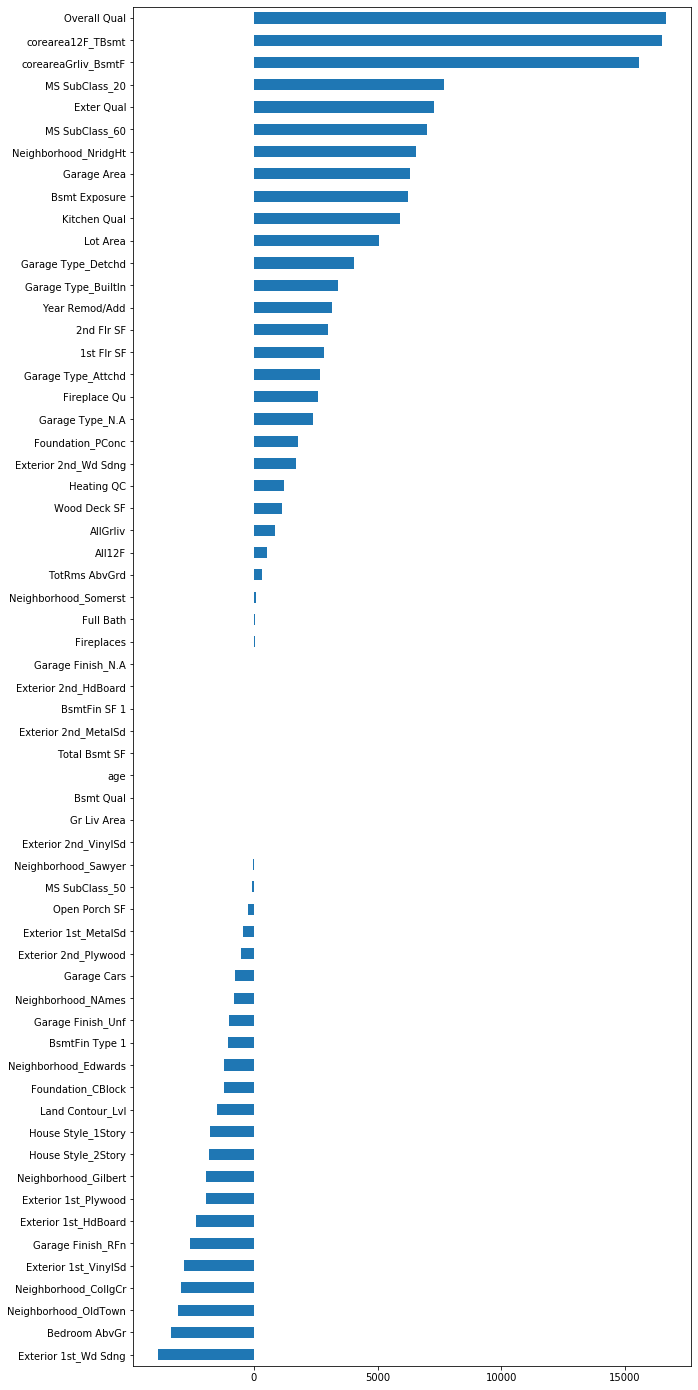

In [81]:
pd.Series(lasso.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

### Interpretation

**Test data looks good fit as well but it is very difficult to explain to stakeholders.**

**Also, try rerunning the notebook a few times. The number of 0 in the coeffients matrix in Lasso will change... primarily due to it doing CV with many correlated features and abitarily choose 1 of them.**

*Perhaps a Elastic Net maybe better?

See below for zero coef



In [82]:
np.count_nonzero(lasso.coef_==0)

8

In [83]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(30)

,variable,coef,abs_coef
10,Overall Qual,16646.118942,16646.118942
23,corearea12F_TBsmt,16501.577753,16501.577753
24,coreareaGrliv_BsmtF,15575.702759,15575.702759
28,MS SubClass_20,7671.822558,7671.822558
11,Exter Qual,7299.703627,7299.703627
30,MS SubClass_60,6984.096258,6984.096258
36,Neighborhood_NridgHt,6539.925014,6539.925014
8,Garage Area,6307.738138,6307.738138
13,Bsmt Exposure,6240.859913,6240.859913
16,Kitchen Qual,5893.256460,5893.256460


## Try Elastic Net regression instead.

In [84]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=200, cv=10)

optimal_enet.fit(X_train_sc, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

81.73478373007505
1.0


C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1316812601.4588623, tolerance: 972476104.4943715
  positive)




**Always comes back to a full 1.0 Lasso regression and usually the same results as lasso from above.** 



In [85]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train_sc, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149975470.05188, tolerance: 865669892.6672746
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207367226.369385, tolerance: 890279781.7525527
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2540607485.1835938, tolerance: 861276602.2469304
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

[0.8925186  0.91262642 0.91008365 0.84799679 0.88844146 0.89694763
 0.89631501 0.87863032 0.89404513 0.81800609]
0.8835611089452524


C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188281928.7583008, tolerance: 890824897.9090711
  positive)
C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 930082338.5350342, tolerance: 849717698.9865516
  positive)


In [86]:
enet.fit(X_train_sc,y_train)

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1316812601.4588623, tolerance: 972476104.4943715
  positive)


ElasticNet(alpha=81.73478373007505, copy_X=True, fit_intercept=True,
           l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [87]:
y_pred = enet.predict(X_test_sc)

In [88]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 18443.171718449506
Root Mean Squared Error: 25335.408176553734


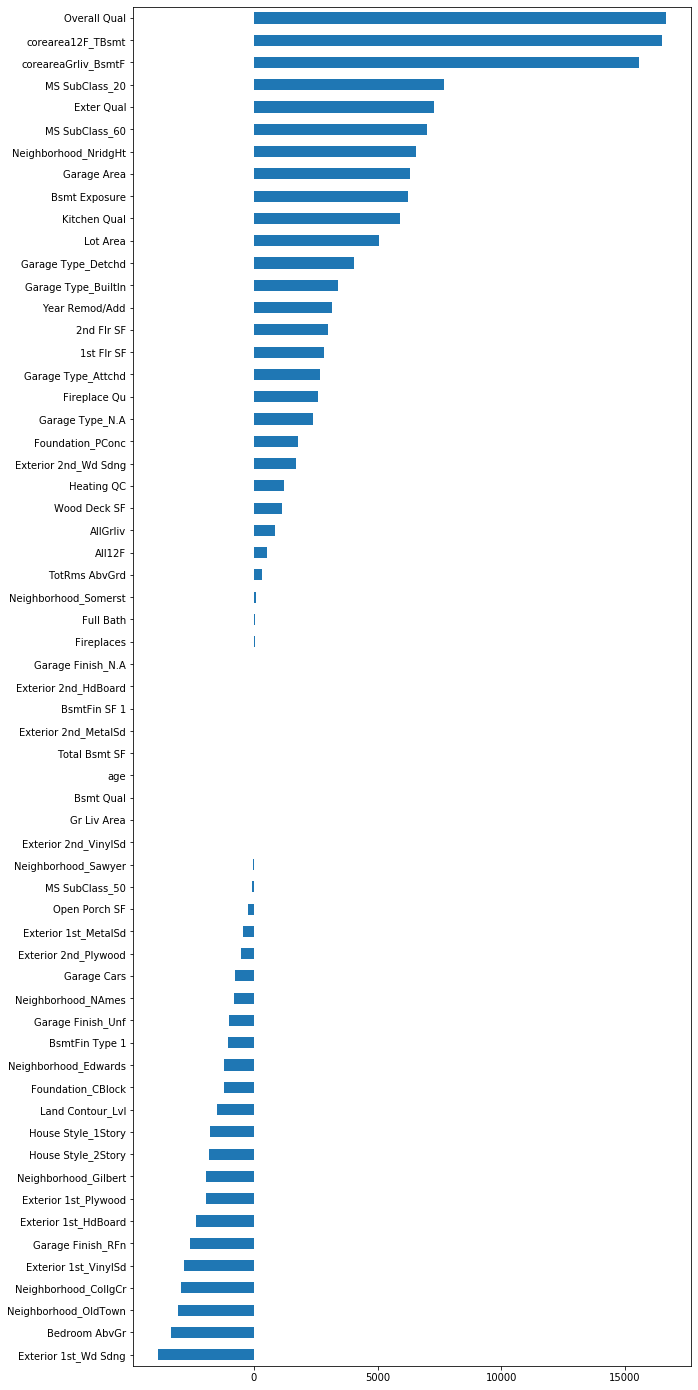

In [89]:
pd.Series(enet.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

### Interpretation

**The Elastic Net here is forced back into a Lasso regression! Test data looks good fit as well but it is very difficult to explain to stakeholders.**

**Faces the same problem. As it is forced back to be a Lasso.**

*No choice but to use Ridge to do L2 and manual drop features as Lasso arbitarily chooses 1 of the correlated and drops the rest.

See below for zero coef

In [90]:
np.count_nonzero(enet.coef_==0)

8

In [91]:
enet_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':enet.coef_,
                            'abs_coef':np.abs(enet.coef_)})

enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

enet_coefs.head(30)

,variable,coef,abs_coef
10,Overall Qual,16646.118942,16646.118942
23,corearea12F_TBsmt,16501.577753,16501.577753
24,coreareaGrliv_BsmtF,15575.702759,15575.702759
28,MS SubClass_20,7671.822558,7671.822558
11,Exter Qual,7299.703627,7299.703627
30,MS SubClass_60,6984.096258,6984.096258
36,Neighborhood_NridgHt,6539.925014,6539.925014
8,Garage Area,6307.738138,6307.738138
13,Bsmt Exposure,6240.859913,6240.859913
16,Kitchen Qual,5893.256460,5893.256460


## Ridge Regression

In [92]:
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas,cv=5)
ridge_model = ridge_model.fit(X_train_sc, y_train)

In [93]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

60.80224261649424

In [94]:
ridge = Ridge(alpha=ridge_optimal_alpha)

ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=5)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.90205034 0.88667752 0.89035728 0.88627908 0.84695701]
0.8824642440494006


In [95]:
ridge.fit(X_train_sc,y_train)

Ridge(alpha=60.80224261649424, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [96]:
y_pred = ridge.predict(X_test_sc)

In [97]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 18413.343207460126
Root Mean Squared Error: 25322.41507101315


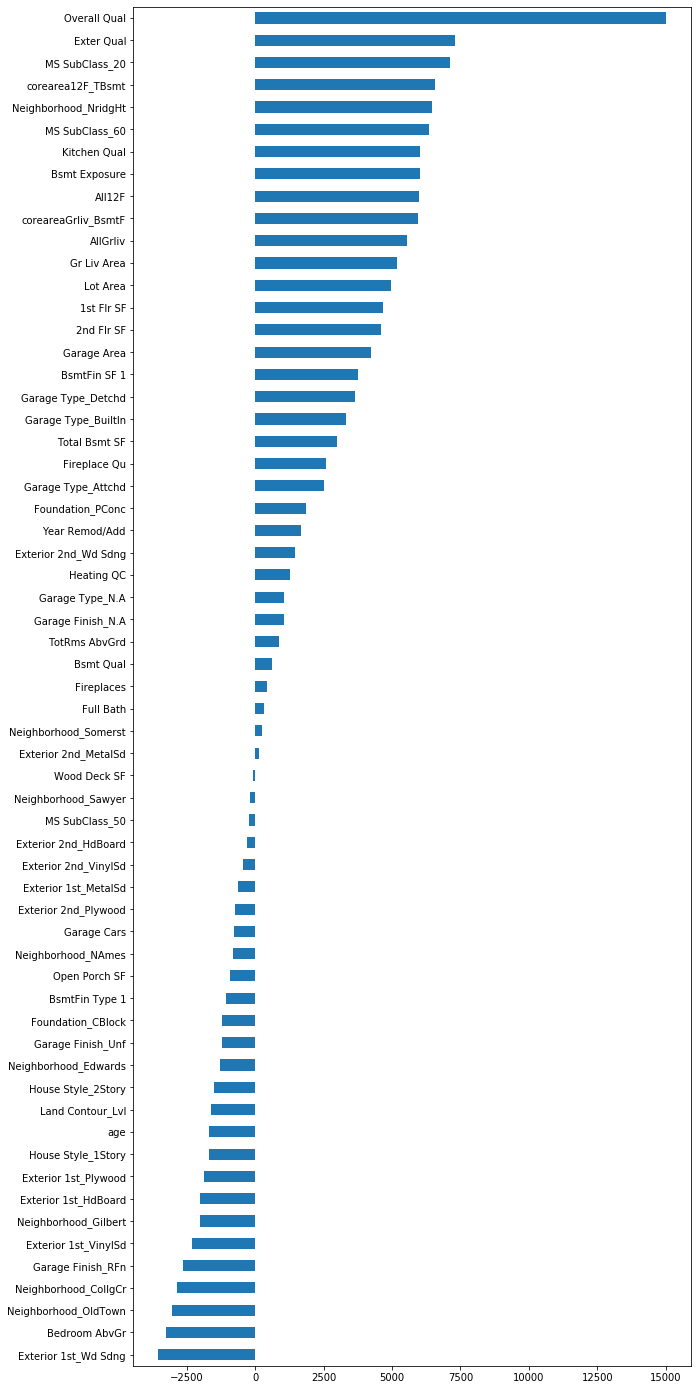

In [98]:
pd.Series(ridge.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

In [99]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(30)

,variable,coef,abs_coef
10,Overall Qual,15000.099408,15000.099408
11,Exter Qual,7305.860353,7305.860353
28,MS SubClass_20,7117.277304,7117.277304
23,corearea12F_TBsmt,6560.462761,6560.462761
36,Neighborhood_NridgHt,6473.914187,6473.914187
30,MS SubClass_60,6349.691238,6349.691238
16,Kitchen Qual,6039.814601,6039.814601
13,Bsmt Exposure,6011.455789,6011.455789
25,All12F,5997.657847,5997.657847
24,coreareaGrliv_BsmtF,5938.486665,5938.486665


**I tried rerunning the workbook a few times and the features in the top 30 is rather stable.**

Will reapply Ridge on the top 30.

In [100]:
cleanedridge = ridge_coefs.head(30)

In [101]:
# reassign back the list from cleanedridge to extract it from final
cleanedridge = final[cleanedridge['variable']].copy()

In [102]:
features = [col for col in cleanedridge.columns if col != 'SalePrice']
X = cleanedridge
y = final['SalePrice']

In [103]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [104]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [105]:
r_alphas = np.logspace(0, 5, 200)
ridge_model2 = RidgeCV(alphas=r_alphas,cv=5)
ridge_model2 = ridge_model2.fit(X_train_sc, y_train)

In [106]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model2.alpha_
ridge_optimal_alpha

48.241087041653714

In [107]:
ridge2 = Ridge(alpha=ridge_optimal_alpha)

ridge2_scores = cross_val_score(ridge2, X_train_sc, y_train, cv=5)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.90205034 0.88667752 0.89035728 0.88627908 0.84695701]
0.8824642440494006


In [108]:
ridge2.fit(X_train_sc,y_train)

Ridge(alpha=48.241087041653714, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [109]:
r2 = ridge2.score(X_test_sc, y_test)

In [110]:
y_pred = ridge2.predict(X_test_sc)

In [111]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 20151.20282991538
Root Mean Squared Error: 29068.0078973779


In [112]:
Adj_r2 = 1-(1-r2)*(2044-1)/(2044-30-1)

Adj_r2

0.8789112560367289

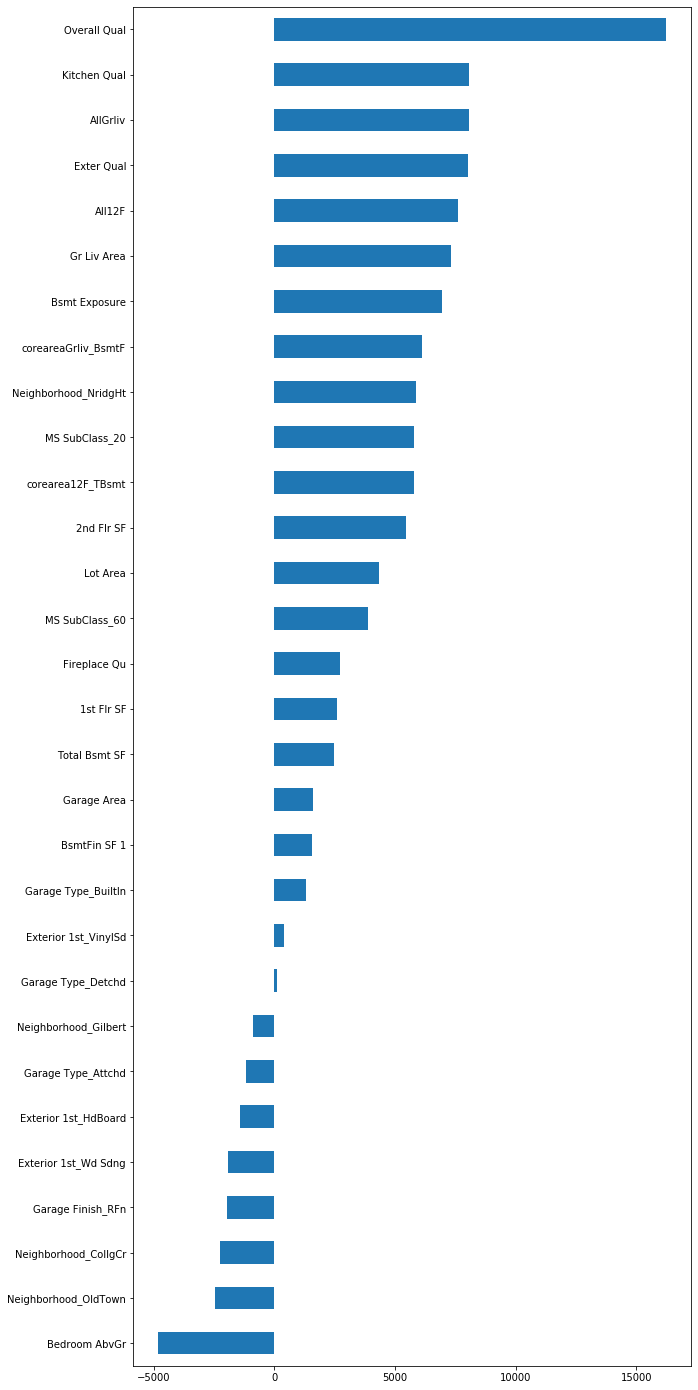

In [113]:
pd.Series(ridge2.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

<a id='8.-Conclusion'></a>
## 8. Conclusion

Preferred Model choice: Simple MLR
Using `All12F`,`Overall Qual` & `age`

**Why?**

- Based on the Historgram of Sale Price, most of the property cost >$100,000
- The deviation of the mean absolute error and root mean square error from the complicated 30 feature models does not differ that much in the grand scale of things. Ridge2 RMSE is 6K less than MLR.
- Simple MLR Adjust R2 is 0.82 while Ridge2 is 0.87

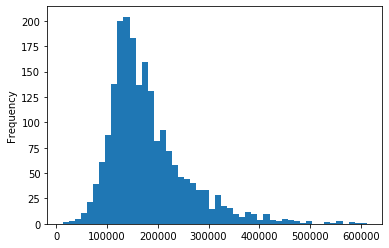

In [114]:
y.plot(kind='hist',bins=50)

<a id='9.-Loading-the-CSV-to-predict-the-test-set'></a>
## 9. Loading the CSV to predict the test set

In [115]:
# load the training set
kaggletest = pd.read_csv('datasets/test.csv')

In [116]:
# we need All12F,Overall Qual & age
# Based on info here, there is no missing value for the predictors we will need to form.

kaggletest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
Id                 879 non-null int64
PID                879 non-null int64
MS SubClass        879 non-null int64
MS Zoning          879 non-null object
Lot Frontage       719 non-null float64
Lot Area           879 non-null int64
Street             879 non-null object
Alley              58 non-null object
Lot Shape          879 non-null object
Land Contour       879 non-null object
Utilities          879 non-null object
Lot Config         879 non-null object
Land Slope         879 non-null object
Neighborhood       879 non-null object
Condition 1        879 non-null object
Condition 2        879 non-null object
Bldg Type          879 non-null object
House Style        879 non-null object
Overall Qual       879 non-null int64
Overall Cond       879 non-null int64
Year Built         879 non-null int64
Year Remod/Add     879 non-null int64
Roof Style         879 non-null object
Roof M

In [117]:
# resetting index to use Id as index
kaggletest.set_index(keys='Id',inplace=True)

In [118]:
# to reform All12F and age
kaggletest['All12F'] = kaggletest['1st Flr SF'] + kaggletest['2nd Flr SF'] + kaggletest['Total Bsmt SF'] + kaggletest['Wood Deck SF'] + kaggletest['Open Porch SF'] + kaggletest['Garage Area']
kaggletest['age'] = 2010 - kaggletest['Year Remod/Add']


In [119]:
kaggle_X_test = kaggletest[['All12F','Overall Qual','age']]

In [120]:
# From MLR
X = cleantrain[['All12F','Overall Qual','age']]
y = cleantrain['SalePrice']

In [121]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [122]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(kaggle_X_test)

In [123]:
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [124]:
y_pred = lr.predict(X_test_sc)

y_pred

array([181442.59914578, 231334.56255701, 185230.0040608 , 133168.09040101,
       182828.98067232,  77951.14694587, 106945.34087027, 153097.78324174,
       209385.45256689, 182710.21058028, 174056.66530032, 152844.8136692 ,
       172113.56858177, 297493.33500586, 175689.0086731 ,  99220.78235021,
       167058.14658189, 118283.10192959, 221170.96334771, 223575.22025828,
       153879.59667749, 133820.41611414, 215475.56229863, 147522.47094412,
       209089.4371299 , 104653.37822874, 136366.76226407, 137764.79897484,
       145045.81860448,   9323.35706342, 100409.65113252,  82679.16282854,
       290820.21226553, 159795.98041566, 231641.73225144, 183341.26704052,
       130831.76323562,  47581.09857263,  91592.81166027, 229646.66707947,
       162211.45588361, 213171.25299318, 160381.79031948, 160179.56581737,
       228835.66365549,  89454.68871878, 215224.69814162, 122909.0957681 ,
       119663.35776239, 116137.97126181, 108134.74155588, 233967.53233914,
       281150.64216427, 1

In [125]:
kagglesubmit = pd.DataFrame({'Id':kaggletest.index,
                            'SalePrice':y_pred,
                            })

kagglesubmit.set_index(keys='Id',inplace=True)

In [126]:
kagglesubmit.to_csv('kagglesubmission.csv')

<img src="kaggle.jpg">